# Meta Analysis of the Datasets for the Epi² pilot project 
# PYTHON 3 Notebook
### Adrien Leger / EMBL EBI
### Starting date 23/05/2016

---
# Import general package and definition of specific functions

In [14]:
%matplotlib inline

from pycl import bash, head, dict_to_md, supersplit, colsum, reformat_table, linerange, fastcount, simplecount, dict_to_report
import datetime
import numpy as np
import scipy.stats as stats
import pylab as pl
from Bio import Entrez
from glob import glob
from pprint import pprint as pp
from os.path import basename

pl.rcParams['figure.figsize'] = 30, 10  # that's default image size for this interactive session

def generate_header (PMID, cell, modification, method):
    h = "# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver\n"
    h+= "# Maurits Evers (maurits.evers@anu.edu.au)\n"
    h+= "# Data cleaned and standardized. {}\n".format(str (datetime.datetime.today()))
    h+= "# Adrien Leger (aleg@ebi.ac.uk)\n"
    h+= "# RNA_modification={}|Cell_type={}|Analysis_method={}|Pubmed_ID={}\n".format(modification, cell, method, PMID)
    h+= "# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"
    return h

def file_summary(file, separator=["\t", "|"], max_items=10):
    n_line = fastcount(file)
    print("Filename:\t{}".format(file))
    print("Total lines:\t{}\n".format(n_line))
    linerange(file, [[0,9],[n_line-5, n_line-1]])
    print(colsum(file, header=False, ignore_hashtag_line=True, separator=separator, max_items=max_items))

def distrib_peak_len (file, range=None, bins=50):
    h = []
    for line in open (file):    
        if line[0] != "#":
            ls = line.split("\t")
            delta = abs(int(ls[1])-int(ls[2]))
            h.append(delta)
        h.sort()

    pl.hist(h,normed=True, range=range, bins=bins)
    pl.show()

def pubmed_fetch(pmid):
    Entrez.email = 'your.email@example.com'
    handle = Entrez.efetch (db='pubmed', id=pmid, retmode='xml', )
    return Entrez.read(handle)[0]

def pmid_to_info(pmid):
    results = pubmed_fetch(pmid)
    try:
        title = results['MedlineCitation']['Article']['ArticleTitle']
    except (KeyError, IndexError) as E:
        title = "NA"
    try:
        first_name = results['MedlineCitation']['Article']['AuthorList'][0]['LastName']
    except (KeyError, IndexError) as E:
        first_name = "NA"
    try:
        Year = results['MedlineCitation']['Article']['ArticleDate'][0]['Year']
    except (KeyError, IndexError) as E:
        Year = "NA"
    try:
        Month = results['MedlineCitation']['Article']['ArticleDate'][0]['Month']
    except (KeyError, IndexError) as E:
        Month = "NA"
    try:
        Day = results['MedlineCitation']['Article']['ArticleDate'][0]['Day']
    except (KeyError, IndexError) as E:
        Day = "NA"
    
    d = {"title":title, "first_name":first_name, "Year":Year, "Month":Month, "Day":Day}
        
    return d

---
# RNA PTM DATASETS

**I collected datasets from different sources. The 2 big database containing Inosine edition RADAR and DARNED as well as all the datasets cited in the recent review about lncRNA and epitranscriptomics from Shaffik et al. In addition I also have 2 recent datasets for m1A and m6A/Am6A. All the datasets need to be carefully reviewed, reformated to BED6 format, converted to hg38 reference genome and reannotated with recent genecode annotations. See overview of the datasets in the table below**


|Modification|Article|PMID|Method|Model|Number of peaks|
|---|---|---|---|---|---|---|
|Inosine|[Z Peng et al. Nat Biotechnol 30, 253-60 (2012)](http://www.ncbi.nlm.nih.gov/pubmed/22327324)|22327324|A to I editing|lymphoblastoid cell line of a male Han Chinese individual |22686|
|Inosine|[M Sakurai et al. Genome Res 24, 522-34 (2014)](http://www.ncbi.nlm.nih.gov/pubmed/24407955)|24407955|ICE-seq|human adult brain tissue|20482|
|m5C|[S Hussain et al. Cell Rep 4, 255-61 (2013)](http://www.ncbi.nlm.nih.gov/pubmed/23871666)|23871666|miCLIP|HEK293|1084|
|m5C|[V Khoddami et al. Nat Biotechnol 31, 458-64 (2013)](http://www.ncbi.nlm.nih.gov/pubmed/23604283)|23604283|AzaIP|MEF (DNMT2 KD and WT)|20553|
|m5C|[JE Squires et al. Nucleic Acids Res 40, 5023-33 (2012)](http://www.ncbi.nlm.nih.gov/pubmed/22344696)|22344696|bisulfite_seq|HeLa|10490|
|m6A|[D Dominissini et al. Nature 485, 201-6 (2012)](http://www.ncbi.nlm.nih.gov/pubmed/22575960)|22575960|M6A-seq|HepG2|25776|
|m6A|[KD Meyer et al. Cell 149, 1635-46 (2012)](http://www.ncbi.nlm.nih.gov/pubmed/22608085)|22608085|MeRIP-Seq|HEK293|4341|
|m6A and m6Am |[B Linder et al. Nat Methods 12, 767-72 (2015)](http://www.ncbi.nlm.nih.gov/pubmed/26121403)|26121403|miCLIP|HEK293|15167|
|m1A|[D Dominissini et al. Nature 530, 441-6 (2016)](http://www.ncbi.nlm.nih.gov/pubmed/26863196)|26863196|M1A-seq|HeLa/HepG2/HEK293|2129 HEK293 / 8873 HeLa / 21125 HEPG2|
|pseudouridylation|[TM Carlile et al. Nature 515, 143-6 (2014)](http://www.ncbi.nlm.nih.gov/pubmed/25192136)|25192136|Pseudo-seq|HeLa|8|
|pseudouridylation|[X Li et al. Nat Chem Biol 11, 592-7 (2015)](http://www.ncbi.nlm.nih.gov/pubmed/26075521)|26075521|CeU-Seq|HEK293|1489|
|pseudouridylation|[S Schwartz et al. Cell 159, 148-62 (2014)](http://www.ncbi.nlm.nih.gov/pubmed/25219674)|25219674|Ψ-seq |HEK293 / Primary Fibroblast Data Mixed|396|
|Inosine|[DARNED database](http://darned.ucc.ie/)|15731336 19275900 21984433 15797904 16594986 18684997 16100382 19478186 21725310 15545495 21960545 15258596 22028664 22327324 15342557 22484847|Variable/not indicated = Mainly comparison genome and transcriptome|Variable/ detailed by tissue. Still a little messy after cleaning|333216 / Clean = 309692|
|Inosine|[RADAR database](http://rnaedit.com/about/)|21960545 22327324 22484847 23291724|Variable/not indicated = Mainly comparison genome and transcriptome|U87 /Illumina_Bodymap/ Brain/ YH|2576460 / Clean = 1342374 / Uniq sites = 974773|

---
## DARNED

### Reformat DARNED Database

**The file dowloaded from DARNED is not a bed file. I need to modify it to comply with the standard format**

In [62]:
file_summary("./PTM_Original_Datasets/DARNED_human_hg19_all_sites.txt")

Filename:	./PTM_Original_Datasets/DARNED_human_hg19_all_sites.txt
Total lines:	333217

0	#DARNED  
1	#chrom	coordinate	strand	inchr	inrna	gene	seqReg	exReg	source	PubMed ID
2	4	250721	-	A	I		O		DIENCEPHALON	19478186
3	4	475468	-	A	I	ZNF721	I		THYMUS	15342557
4	4	476348	-	A	I	ZNF721	I		THYMUS	15342557
5	4	476410	-	A	I	ZNF721	I		THYMUS	15342557
6	4	476414	-	A	I	ZNF721	I		THYMUS	15342557
7	4	476424	-	A	I	ZNF721	I		THYMUS	15342557
8	4	476487	-	A	I	ZNF721	I		THYMUS	15342557
9	4	476489	-	A	I	ZNF721	I		THYMUS	15342557

333212	X	3737545	-	A	G	LOC389906	I		LYMPHOBLASTOID CELL	22484847
333213	X	3737714	-	A	G	LOC389906	I		LYMPHOBLASTOID CELL	22484847
333214	X	3737716	-	A	G	LOC389906	I		LYMPHOBLASTOID CELL	22484847
333215	X	3738584	-	G	T	LOC389906	I		LYMPHOBLASTOID CELL	22484847
333216	X	3738585	-	G	T	LOC389906	I		LYMPHOBLASTOID CELL	22484847

|0|1|2|12|3|7|5|6|4|8|19|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|50666|34880|28526|28318|28036|21071|19282|16767|15833|150

**DARNED is a little messy and hard to convert since the position with the same PMID/OR sample types where fused in the same Site. It makes it difficult to parse. I think it would be better if I duplicate the site with the several PMID and sample type. I just need to verify if the number of fields in PMID and cell type is similar and if they correspond to each other, ie first in cell type = first in PMID**

In [55]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

header = "# DARNED database Human all sites hg19 coordinates\n"
header+= "# Data cleaned, filtered for Inosine editing, standardized and converted to BED6 format\n"
header+= "# Adrien Leger (aleg@ebi.ac.uk) - {}\n".format(str (datetime.datetime.today()))
header+= "# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

reformat_table(
    input_file = "./PTM_Original_Datasets/DARNED_human_hg19_all_sites.txt",
    output_file = "./PTM_Original_Datasets/DARNED_human_hg19_inosine.bed",
    init_template = [0,"\t",1,"\t",2,"\t",3,"\t",4,"\t",5,"\t",6,"\t",7,"\t",8,"\t",9],
    final_template = ["chr",0,"\t",1,"\t",1,"\t",3,">",4,"|",8,"|-|",9,"|",5,"\t0\t",2],
    keep_original_header = False,
    header = header,
    replace_internal_space = '_',
    replace_null_val = "-",
    filter_dict = {0:["-"],1:["-"],2:["?"],3:["T","G","C"],4:["C","T","A","U"],8:["-"],9:["-"]},
    subst_dict = {4:{"G":"I"}}
    )

file_summary("./PTM_Original_Datasets/DARNED_human_hg19_inosine.bed")

333215 Lines processed	285250 Lines pass	47965 Lines filtered out	0 Lines fail

Filename:	./DARNED/DARNED_human_hg19_inosine.bed
Total lines:	285254

0	# DARNED database Human all sites hg19 coordinates
1	# Data cleaned, filtered for Inosine editing, standardized and converted to BED6 format
2	# Adrien Leger (aleg@ebi.ac.uk) - 2016-06-09 11:23:04.068087
3	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
4	chr4	250721	250721	A>I|DIENCEPHALON|-|19478186|-	0	-
5	chr4	475468	475468	A>I|THYMUS|-|15342557|ZNF721	0	-
6	chr4	476348	476348	A>I|THYMUS|-|15342557|ZNF721	0	-
7	chr4	476410	476410	A>I|THYMUS|-|15342557|ZNF721	0	-
8	chr4	476414	476414	A>I|THYMUS|-|15342557|ZNF721	0	-
9	chr4	476424	476424	A>I|THYMUS|-|15342557|ZNF721	0	-

285249	chrX	3626805	3626805	A>I|LYMPHOBLASTOID_CELL|-|22484847|PRKX	0	-
285250	chrX	3737454	3737454	A>I|LYMPHOBLASTOID_CELL|-|22484847|LOC389906	0	-
285251	chrX	3737545	3737545	A>I|LYMPHOBLASTOID_CELL|-|22484847|LOC389906	0	-
285252	chrX	3737

**I reformated and filtered the database with reformat_table to be BED6 compatible. I removed the fields lacking either chromosome, position, tissue, and PID as well as with unknown strand. In addition I also selected only A>I and A>G transitions (same thing). This filtering step eliminated 47965 sites**

In [56]:
d={}

with open("./PTM_Original_Datasets/DARNED_human_hg19_inosine.bed", "r") as f:
    for line in f:
        if line [0] !="#":
            ls = supersplit(line, ["\t","|"])
            n_tissue = len(ls[4].split(","))
            n_PMID = len(ls[6].split(","))
            key="{}:{}".format(n_tissue,n_PMID)
            if key not in d:
                d[key]=0
            d[key]+=1

print (d)

{'5:2': 32, '4:4': 28, '3:4': 49, '1:4': 5, '7:2': 1, '8:4': 1, '6:1': 4, '2:2': 3125, '4:2': 52, '3:3': 215, '1:2': 4618, '3:2': 285, '3:5': 2, '2:4': 18, '5:5': 1, '5:1': 41, '4:3': 50, '6:4': 1, '1:1': 272551, '4:5': 1, '1:3': 181, '4:1': 47, '5:4': 5, '2:5': 1, '6:2': 4, '7:4': 2, '2:3': 386, '3:1': 185, '2:1': 3348, '5:3': 11}


**I tried to see if the PMID and the tissue field always had the same lengh, so I could de multiplex the fused positions. The answer is no, the number of PMID and tissues could be different. However 272551 positions have only 1 tissue and 1 PMID. These are maybe not the more relialable positions but they might be more easy to interprete. The sites with only 1 PMID but several tissues can also be used. Same think for several PMID, 1 tissue. I will demultiplex them so as to have only 1 PMID and 1 tissue by site. Concerning the site with more than 1 PMID and 1 tissue, I will extract then in another backup file.** 

In [57]:
infile = "./PTM_Original_Datasets/DARNED_human_hg19_inosine.bed"
outclean = "./PTM_Original_Datasets/DARNED_human_hg19_inosine_cleaned.bed"
outunclean = "./PTM_Original_Datasets/DARNED_human_hg19_inosine_unclean.bed"

with open(infile, "r") as inf, open(outclean, "w") as outf_clean, open(outunclean, "w") as outf_unclean:
    
    init_sites = uniq = several_tissue = several_pmid = several_all = final_sites = 0  
    
    for line in inf:
        if line [0] == "#":
            outf_clean.write(line)
            outf_unclean.write(line)
        else:
            init_sites += 1
            ls = supersplit(line, ["\t","|"])
            tissue_list = ls[4].split(",")
            PMID_list = ls[6].split(",")
            n_tissue = len(tissue_list)
            n_PMID = len(PMID_list)
            
            if n_tissue == 1:
                
                # 1 PMID, 1 tissue = no problem
                if n_PMID == 1:
                    uniq += 1
                    final_sites += 1
                    outf_clean.write(line)
                
                # Several PMID, 1 tissue = demultiplex PMID lines
                else:
                    several_pmid += 1
                    for PMID in PMID_list:
                        final_sites += 1
                        outf_clean.write("{0}\t{1}\t{2}\t{3}|{4}|{5}|{6}|{7}\t{8}\t{9}".format(
                            ls[0],ls[1],ls[2],ls[3],ls[4],ls[5],PMID.strip(),ls[7],ls[8],ls[9]))
            else:
                
                # 1 PMID, several tissues = demultiplex tissues lines
                if n_PMID == 1:
                    several_tissue += 1
                    for tissue in tissue_list:
                        final_sites += 1
                        outf_clean.write("{0}\t{1}\t{2}\t{3}|{4}|{5}|{6}|{7}\t{8}\t{9}".format(
                            ls[0],ls[1],ls[2],ls[3],tissue.strip().strip("_").strip("."),ls[5],ls[6],ls[7],ls[8],ls[9]))
                
                # Several PMID, several tissues = extract the line in uncleanable datasets
                else:
                    several_all += 1
                    outf_unclean.write(line)

print("Initial sites: ", init_sites)
print("Final clean sites: ", final_sites)
print("1 PMID 1 tissu: ", uniq)
print("1 PMID ++ tissue: ", several_tissue)
print("++ PMID 1 tissue: ", several_pmid)
print("++ PMID ++ tissue: ", several_all)

file_summary(outclean)
file_summary(outunclean)

Initial sites:  285250
Final clean sites:  290018
1 PMID 1 tissu:  272551
1 PMID ++ tissue:  3625
++ PMID 1 tissue:  4804
++ PMID ++ tissue:  4270
Filename:	./DARNED/DARNED_human_hg19_inosine_cleaned.bed
Total lines:	290022

0	# DARNED database Human all sites hg19 coordinates
1	# Data cleaned, filtered for Inosine editing, standardized and converted to BED6 format
2	# Adrien Leger (aleg@ebi.ac.uk) - 2016-06-09 11:23:04.068087
3	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
4	chr4	250721	250721	A>I|DIENCEPHALON|-|19478186|-	0	-
5	chr4	475468	475468	A>I|THYMUS|-|15342557|ZNF721	0	-
6	chr4	476348	476348	A>I|THYMUS|-|15342557|ZNF721	0	-
7	chr4	476410	476410	A>I|THYMUS|-|15342557|ZNF721	0	-
8	chr4	476414	476414	A>I|THYMUS|-|15342557|ZNF721	0	-
9	chr4	476424	476424	A>I|THYMUS|-|15342557|ZNF721	0	-

290017	chrX	3626805	3626805	A>I|LYMPHOBLASTOID_CELL|-|22484847|PRKX	0	-
290018	chrX	3737454	3737454	A>I|LYMPHOBLASTOID_CELL|-|22484847|LOC389906	0	-
290019	chrX	373754

**I only lost 4270 sites with several PMID and several tissue. Some sites where demultiplexed and I now have 290018 sites with 1 PMID and 1 tissue**

### Convert DARNED coordinates from hg19 to hg39 with Crossmap

**Coordinate conversion using CrossMap and a hg19 tp hg38 chain file in BASH**

In [58]:
# Conversion to hg38 with Crossmap/liftover
lifover_chainfile = "../LiftOver_chain_files/hg19ToHg38.over.chain.gz"
input_bed = "./PTM_Original_Datasets/DARNED_human_hg19_inosine_cleaned.bed"
temp_bed = "./PTM_Original_Datasets/DARNED_human_hg38_inosine_temp.bed"

cmd = "CrossMap.py bed {} {} {}".format(lifover_chainfile, input_bed, temp_bed)  
bash(cmd)

# Rewriting and updating of the header removed by Crossmap
final_bed = "./PTM_Original_Datasets/DARNED_human_hg38_inosine_cleaned.bed"

header = "# DARNED database Human all sites hg38 coordinates\n"
header+= "# Data cleaned, filtered for Inosine editing, standardized, converted to BED6 format and updated to hg38 coordinates\n"
header+= "# Adrien Leger (aleg@ebi.ac.uk) - {}\n".format(str (datetime.datetime.today()))
header+= "# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

with open (temp_bed, "r") as infile, open (final_bed, "w") as outfile:
    outfile.write (header)
    for line in infile:
        outfile.write (line)

file_summary(final_bed)


@ 2016-06-09 11:27:48: Read chain_file:  ../LiftOver_chain_files/hg19ToHg38.over.chain.gz

Filename:	./DARNED/DARNED_human_hg38_inosine_cleaned.bed
Total lines:	290002

0	# DARNED database Human all sites hg38 coordinates
1	# Data cleaned, filtered for Inosine editing, standardized, converted to BED6 format and updated to hg38 coordinates
2	# Adrien Leger (aleg@ebi.ac.uk) - 2016-06-09 11:27:51.339572
3	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
4	chr4	256932	256932	A>I|DIENCEPHALON|-|19478186|-	0	-
5	chr4	481679	481679	A>I|THYMUS|-|15342557|ZNF721	0	-
6	chr4	482559	482559	A>I|THYMUS|-|15342557|ZNF721	0	-
7	chr4	482621	482621	A>I|THYMUS|-|15342557|ZNF721	0	-
8	chr4	482625	482625	A>I|THYMUS|-|15342557|ZNF721	0	-
9	chr4	482635	482635	A>I|THYMUS|-|15342557|ZNF721	0	-

289997	chrX	3708764	3708764	A>I|LYMPHOBLASTOID_CELL|-|22484847|PRKX	0	-
289998	chrX	3819413	3819413	A>I|LYMPHOBLASTOID_CELL|-|22484847|LOC389906	0	-
289999	chrX	3819504	3819504	A>I|LYMPHOBLASTO

**The conversion resulted in the lost of 16 sites, which is neglectable compared with the 290002 sites in the database**

---
## RADAR

### Reformat RADAR Database

**The file dowloaded from DARNED is not a bed file. I need to modify it to comply with the standard format. The format of the mane file *Human_AG_all_hg19_v2.txt* is the following: **

In [45]:
file_summary("./PTM_Original_Datasets/RADAR_human_hg19_v2_primary.txt", separator=["\t"])

Filename:	./RADAR/RADAR_human_hg19_v2_primary.txt
Total lines:	2576460

0	#chromosome	position	gene	strand	annot1	annot2	alu?	non_alu_repetitive?	conservation_chimp	conservation_rhesus	conservation_mouse
1	chr1	206256301	C1orf186	-	intronic	intronic	no	no	N	N	N
2	chr6	116991832	intergenic	-	intergenic	intergenic	no	no	N	N	N
3	chr7	30504355	NOD1	-	intronic	intronic	no	no	N	N	N
4	chr1	85127959	SSX2IP	-	Syn	Gln->Gln	no	no	N	N	N
5	chr15	100203261	MEF2A	+	intronic	intronic	no	no	N	N	N
6	chr6	102372915	GRIK2	+	intronic	intronic	no	no	N	N	N
7	chr9	135788925	TSC1	-	intronic	intronic	no	no	N	N	N
8	chr17	74414054	UBE2O	-	intronic	intronic	no	no	N	N	N
9	chr15	73069310	ADPGK	-	intronic	intronic	no	no	N	N	N

2576455	chr1	92591586	intergenic	-	intergenic	intergenic	no	no	N	N	N
2576456	chr1	92591608	intergenic	-	intergenic	intergenic	no	no	N	N	N
2576457	chr1	92591631	intergenic	-	intergenic	intergenic	no	no	N	N	N
2576458	chr1	92591653	intergenic	-	intergenic	intergenic	no	no	N	N	N
2576459	chr1	925916

**I am not interested by the conservation fields, the annotation and the repetitive nature, but I will keep chromosome, position, gene and strand.**
**Additional information is also available in a secondary database file that I found hidden on RADAR website. The information includes the original publication and the source of the biological sample. The information is only available for around half of the sites from 4 publications. I will only retain these richly annotated sites. The same sites can have bmultiple entries in the secondary file since I could have been reported by several papers in several tissues. I will keep a line for each independantly discovered site. The coverage and editing level could be interesting to save too.**

In [46]:
file_summary("./PTM_Original_Datasets/RADAR_human_hg19_v2_secondary.txt")

Filename:	./RADAR/RADAR_human_hg19_v2_secondary.txt
Total lines:	1343465

0	#location	reference	tissue	coverage	editing_level(%)
1	chr1:1037916	Peng et al 2012	Lymphoblastoid cell line	9	66.67
2	chr1:1156882	Peng et al 2012	Lymphoblastoid cell line	42	36.59
3	chr1:1157460	Peng et al 2012	Lymphoblastoid cell line	66	22.73
4	chr1:1252441	Peng et al 2012	Lymphoblastoid cell line	11	72.73
5	chr1:1252443	Peng et al 2012	Lymphoblastoid cell line	11	45.45
6	chr1:1253357	Peng et al 2012	Lymphoblastoid cell line	31	32.26
7	chr1:1253944	Peng et al 2012	Lymphoblastoid cell line	28	46.43
8	chr1:1418532	Peng et al 2012	Lymphoblastoid cell line	5	60.00
9	chr1:1419773	Peng et al 2012	Lymphoblastoid cell line	10	60.00

1343460	chrX:119056591	Bahn et al 2012	U87 cell line	5	60
1343461	chrX:123047295	Bahn et al 2012	U87 cell line	17	71
1343462	chrX:135300016	Bahn et al 2012	U87 cell line	9	55
1343463	chrX:153702725	Bahn et al 2012	U87 cell line	15	33
1343464	chrX:153702725	Bahn et al 2012	U87 cell line	

**The operation is quite complex since I will have to fuse the 2 files and extract only specific values. I need to code a specific parser. The main RADAR file will be parsed and organised as a simple embed dict. The secondary file will be the more important since I will start parsing from it to find the complementary information in the main database file. Each site will be added to a list of Site objects, that will be subsequently iterated to combine with the main database before writing in a new Bed formated file.**

In [108]:
# Create a structured dict of dict to parse the main database file
from collections import OrderedDict

def parse_RADAR_main (file):
    
    # Define the top level access dict
    radar_dict = OrderedDict() 
    
    for line in open (file, "r"):
        if line[0] != "#":
            
            sl = line.split("\t")

            assert len(sl) == 11      
            chromosome, position, gene, strand = sl[0].strip(), int(sl[1].strip()), sl[2].strip(), sl[3].strip()

            if chromosome not in radar_dict:
                radar_dict[chromosome] = OrderedDict()

            # There should be only one line per position
            assert position not in radar_dict[chromosome]
            radar_dict[chromosome][position] = {"gene":gene,"strand":strand}
    
    return radar_dict
        

In [109]:
# Create a class to store a line of the additional file.

from collections import OrderedDict

class Site (object):
    
    #~~~~~~~CLASS FIELDS~~~~~~~#
    # Table of correspondance reference => PMID
    TITLE_TO_PMID = {
        "Peng et al 2012":"22327324",
        "Bahn et al 2012":"21960545",
        "Ramaswami et al 2012":"22484847",
        "Ramaswami et al 2013":"23291724",
        }
    
    # Table of correspondance reference => PMID
    TISSUE_TO_SAMPLE = {
        "Brain":"Brain",
        "Illumina Bodymap":"Illumina_Bodymap",
        "Lymphoblastoid cell line":"YH",
        "U87 cell line":"U87MG"
        }

    #~~~~~~~FONDAMENTAL METHODS~~~~~~~#
    # Parse a line of the aditional information file
    def __init__(self, line, ):
        sl = line.strip().split("\t")
        
        self.chromosome = sl[0].split(":")[0].strip()
        self.position = int(sl[0].split(":")[1].strip())
        self.PMID = self.TITLE_TO_PMID[sl[1].strip()]
        self.tissue = self.TISSUE_TO_SAMPLE[sl[2].strip()]
        self.coverage = sl[3].strip()
        self.editing_level = sl[4].strip()
    
    # Fundamental class methods str and repr
    def __repr__(self):
        msg = "SITE CLASS\n"
        # list all values in object dict in alphabetical order
        keylist = [key for key in self.__dict__.keys()]
        keylist.sort()
        for key in keylist:
            msg+="\t{}\t{}\n".format(key, self.__dict__[key])
        return (msg)

    def __str__(self):
        return self.__repr__()

In [110]:
a = Site("chr1:1037916	Peng et al 2012	Lymphoblastoid cell line	9	66.67")
print (a)

SITE CLASS
	PMID	22327324
	chromosome	chr1
	coverage	9
	editing_level	66.67
	position	1037916
	tissue	YH



In [111]:
# Create a structured dict of dict to parse the secondary database file
def parse_RADAR_secondary (file):
    
    # Define a list to store Site object (not a dict because of redundancy)
    radar_list = []
    
    for line in open (file, "r"):
        if line[0] != "#":
            radar_list.append(Site(line))
    
    # return a list sorted by chromosome and positions
    return sorted(radar_list, key=lambda Site: (Site.chromosome, Site.position))

**Read the original file, reformat the field and write a new file BED6 compliant.**

    chrom	chromstart	chromend	name	score	orient
    chr4	774138	774138	A>I|LOC100129917|LUNG:LYMPHOBLASTOID_CELL_LINE|15342557:15258596:22327324	0	-

In [112]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"


def reformat_RADAR (main_file, secondary_file, outfile, errfile, header):

    # Read and structure the 2 database files
    print("Parse the main database file")
    main = parse_RADAR_main(main_file)

    print("Parse the secondary database file")
    secondary = parse_RADAR_secondary (secondary_file)

    print("Combine the data together in a new bed formated file")
    with open (outfile, "w+") as csvout, open (errfile, "w+") as errout:
        
        # rewrite header
        csvout.write(header)

        fail = success = 0
        for total, site in enumerate(secondary):

            try:
                line = "{0}\t{1}\t{1}\t{2}|{3}|{4}|{5}|{6}\t{7}\t{8}\n".format(
                    site.chromosome,
                    site.position,
                    "A>I",
                    site.tissue,
                    "-",
                    site.PMID,
                    main[site.chromosome][site.position]["gene"],
                    site.editing_level,
                    main[site.chromosome][site.position]["strand"],
                )
                csvout.write(line)
                success += 1

            except KeyError as E:
                line = "{0}\t{1}\t{2}\t{3}\t{4}\n".format(
                    site.chromosome,
                    site.position,
                    site.tissue,
                    site.PMID,
                    site.editing_level
                )
                errout.write(line)
                fail += 1       

    print ("{} Sites processed\t{} Sites pass\t{} Sites fail".format(total, success, fail))

In [113]:
header = "# RADAR database Human v2 all sites hg19 coordinates\n"
header+= "# Data cleaned, standardized and converted to BED6 format\n"
header+= "# Adrien Leger (aleg@ebi.ac.uk) - {}\n".format(str (datetime.datetime.today()))
header+= "# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

reformat_RADAR(
    main_file = "./PTM_Original_Datasets/RADAR_human_hg19_v2_primary.txt",
    secondary_file = "./PTM_Original_Datasets/RADAR_human_hg19_v2_secondary.txt",
    outfile = "./PTM_Original_Datasets/RADAR_Human_hg19_inosine_cleaned.bed",
    errfile = "./PTM_Original_Datasets/RADAR_Human_hg19_inosine_orphan.bed",
    header = header)

file_summary("./PTM_Original_Datasets/RADAR_Human_hg19_inosine_cleaned.bed")

Parse the main database file
Parse the secondary database file
Combine the data together in a new bed formated file
1343463 Sites processed	1342423 Sites pass	1041 Sites fail
Filename:	./RADAR/RADAR_Human_hg19_inosine_cleaned.bed
Total lines:	1342427

0	# RADAR database Human v2 all sites hg19 coordinates
1	# Data cleaned, standardized and converted to BED6 format
2	# Adrien Leger (aleg@ebi.ac.uk) - 2016-06-09 12:08:57.833547
3	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
4	chr1	651206	651206	A>I|YH|-|22484847|RP5-857K21.4	40	-
5	chr1	666265	666265	A>I|YH|-|22484847|uc009vjm.2	16.7	-
6	chr1	666266	666266	A>I|YH|-|22484847|uc009vjm.2	16.7	-
7	chr1	676236	676236	A>I|YH|-|22484847|uc002khh.2	19.4	-
8	chr1	676236	676236	A>I|YH|-|23291724|uc002khh.2	13	-
9	chr1	676236	676236	A>I|Brain|-|23291724|uc002khh.2	15	-

1342422	chrY	23457758	23457758	A>I|YH|-|22484847|intergenic	18.8	-
1342423	chrY	23475581	23475581	A>I|YH|-|22484847|intergenic	50	+
1342424	chrY	2347559

**After combining information, out of the 1343463 sites in the RADAR secondary file and 2576460 in the RADAR primary file, 1342423 consistant sites were found in both files, ie half of the database site were filtered out because they where not in the 2 database files.**

### Convert RADAR coordinates from hg19 to hg39 with Crossmap

Coordinate conversion using CrossMap in BASH

In [114]:
# Conversion to hg38 with Crossmap/liftover
lifover_chainfile = "../LiftOver_chain_files/hg19ToHg38.over.chain.gz"
input_bed = "./PTM_Original_Datasets/RADAR_Human_hg19_inosine_cleaned.bed"
temp_bed = "./PTM_Original_Datasets/RADAR_Human_hg38_inosine_temp.bed"

cmd = "CrossMap.py bed {} {} {}".format(lifover_chainfile, input_bed, temp_bed)  
bash(cmd)

# Rewriting and updating of the header removed by Crossmap
final_bed = "./PTM_Original_Datasets/RADAR_Human_hg38_inosine_cleaned.bed"

header = "# RADAR database Human v2 all sites hg38 coordinates\n"
header+= "# Data cleaned, standardized, converted to BED6 format and updated to hg38 coordinates\n"
header+= "# Adrien Leger (aleg@ebi.ac.uk) - {}\n".format(str (datetime.datetime.today()))
header+= "# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

with open (temp_bed, "r") as infile, open (final_bed, "w") as outfile:
    outfile.write (header)
    for line in infile:
        outfile.write (line)

file_summary(final_bed)


@ 2016-06-09 12:09:43: Read chain_file:  ../LiftOver_chain_files/hg19ToHg38.over.chain.gz

Filename:	./RADAR/RADAR_Human_hg38_inosine_cleaned.bed
Total lines:	1342378

0	# RADAR database Human v2 all sites hg38 coordinates
1	# Data cleaned, standardized, converted to BED6 format and updated to hg38 coordinates
2	# Adrien Leger (aleg@ebi.ac.uk) - 2016-06-09 12:09:56.855643
3	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
4	chr1	715826	715826	A>I|YH|-|22484847|RP5-857K21.4	40	-
5	chr1	730885	730885	A>I|YH|-|22484847|uc009vjm.2	16.7	-
6	chr1	730886	730886	A>I|YH|-|22484847|uc009vjm.2	16.7	-
7	chr1	740856	740856	A>I|YH|-|22484847|uc002khh.2	19.4	-
8	chr1	740856	740856	A>I|YH|-|23291724|uc002khh.2	13	-
9	chr1	740856	740856	A>I|Brain|-|23291724|uc002khh.2	15	-

1342373	chrY	21295872	21295872	A>I|YH|-|22484847|intergenic	18.8	-
1342374	chrY	21313695	21313695	A>I|YH|-|22484847|intergenic	50	+
1342375	chrY	21313713	21313713	A>I|YH|-|22484847|intergenic	50	+
1342376	c

**Around 10000 additional sites were lost during the conversion from hg19 to hg38**

---
## Shafik et al datasets

### File list and define basic exploratory functions

**The datasets a pretty cleaned and already converted to hg38 build coordinates. However, they are not strandardize and the synthax could be different since the bioinformatician in charge of the analysis tried to keep as much information as possible from the original datasets. I will strandardize the file names, the bed name fields and add reformat the file header. In addition I will explore the datasets to see if the are consistant and decide if I use them or not.**

In [58]:
from glob import glob

In [59]:
for i in sorted(glob("./PTM_Original_Datasets/*.bed")):
    print (i)

./PTM_Original_Datasets/DARNED_human_hg19_inosine.bed
./PTM_Original_Datasets/DARNED_human_hg19_inosine_cleaned.bed
./PTM_Original_Datasets/DARNED_human_hg19_inosine_unclean.bed
./PTM_Original_Datasets/DARNED_human_hg38_inosine_cleaned.bed
./PTM_Original_Datasets/DARNED_human_hg38_inosine_temp.bed
./PTM_Original_Datasets/MeRIPseq_m1A_Dominissini2016_hg38.bed
./PTM_Original_Datasets/RADAR_Human_hg19_inosine_cleaned.bed
./PTM_Original_Datasets/RADAR_Human_hg19_inosine_orphan.bed
./PTM_Original_Datasets/RADAR_Human_hg38_inosine_cleaned.bed
./PTM_Original_Datasets/RADAR_Human_hg38_inosine_temp.bed
./PTM_Original_Datasets/editing_Peng_hg38.bed
./PTM_Original_Datasets/editing_Sakurai_hg38.bed
./PTM_Original_Datasets/m5C_Hussain_hg38.bed
./PTM_Original_Datasets/m5C_Khoddami_hg38.bed
./PTM_Original_Datasets/m5C_Squires_hg38.bed
./PTM_Original_Datasets/m6A_Dominissini_hg38.bed
./PTM_Original_Datasets/m6A_Meyer_hg38.bed
./PTM_Original_Datasets/miCLIP_m6A_Linder2015_hg38.bed
./PTM_Original_Datase

---
### editing_Peng_hg38

In [16]:
infile="./PTM_Original_Datasets/editing_Peng_hg38.bed"
PMID = "22327324"
cell = "YH"
modification = "A>I"
method = "A_to_I_editing"
author = "Peng"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/editing_Peng_hg38.bed
Total lines:	22692

0	# Transcriptome-wide map of editing sites [hg38 coordinates]
1	# Reference: Peng et al., Nat. Biotechnol. 30, 253 (2012) [PMID 22327324, DOI 10.1038/nbt.2122]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	1102535	1102536	Peng|chr1|1027779|-|T|Y|A->G|66.67%|37|C|6|T|3|9|intron|C1orf159	0	-
7	chr1	1221501	1221502	Peng|chr1|1146745|-|T|Y|A->G|36.59%|99|T|26|C|15|42|intron|SDF4	0	-
8	chr1	1222079	1222080	Peng|chr1|1147323|-|T|Y|A->G|22.73%|94|T|51|C|15|66|intron|SDF4	0	-
9	chr1	1251840	1251841	Peng|chr1|1177084|-|T|Y|A->G|56.25%|99|C|9|T|7|16|intergenic|-	0	-

22687	chrY	21272330	21272331	Peng|chrY|21843605|-|T|Y|A->G|58.33%|62|C|7|T|5|12|intergenic|-	0	-
22688	chrY	21272371	21272372	Peng|chrY|21843646|-|T|Y|A->G|81.48%|49|C|22|T|5|27|intergenic|-	0	-
22689	chrY	21288231	21288232	Peng|chrY|21859506|-|T|

In [5]:
print(colsum(infile, colrange=[9], header=False, ignore_hashtag_line=True, separator=["\t", "|"], max_items=20, ret_type="report"))

First line found
9
	A->G	21111
	T->C	715
	G->A	236
	C->T	195
	T->G	69
	C->G	61
	G->C	56
	A->C	53
	T->A	51
	C->A	49
	G->T	45
	A->T	45



**The column 9 contains more than just Inosine transitions(A>G) but also all the other editing sites they found. Here I will focuss on the Inosine only. I need to filter out all the other values** 

In [61]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"|",6,"|",7,"|",8,"|",9,"|",10,"%|",11,"|",12,"|",13,"|",14,"|",15,"|",16,"|",17,"|",18,"\t",19,"\t",20]
final_template=[0,"\t",1,"\t",2,"\t",9,"|",cell,"|",method,"|",PMID,"|",18,"\t",10,"\t",20]

# filter out all but A>G transition which are Inosine transition
filter_dict={9:["T->C","G->A","C->T","T->G","C->G","G->C","A->C","T->A","C->A","G->T","A->T"]}

# Reformat the field value A->G to A>I for standardization 
subst_dict={9:{"A->G":"A>I"}}

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-",
    subst_dict = subst_dict,
    filter_dict = filter_dict )

file_summary(outfile)

22686 Lines processed	21111 Lines pass	1575 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Datasets/Peng_A>I_YH_hg38_cleaned.bed
Total lines:	21117

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-09 16:51:42.099109
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=A>I|Cell_type=YH|Analysis_method=A_to_I_editing|Pubmed_ID=22327324
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	1102535	1102536	A>I|YH|A_to_I_editing|22327324|C1orf159	66.67	-
7	chr1	1221501	1221502	A>I|YH|A_to_I_editing|22327324|SDF4	36.59	-
8	chr1	1222079	1222080	A>I|YH|A_to_I_editing|22327324|SDF4	22.73	-
9	chr1	1251840	1251841	A>I|YH|A_to_I_editing|22327324|-	56.25	-

21112	chrY	21272330	21272331	A>I|YH|A_to_I_editing|22327324|-	58.33	-
21113	chrY	21272371	21272372	A>I|YH|A_to_I_editing|22327324|-	81.48	-
21114	chrY	21288231	21288232	A>I|YH|A_to_I_edit

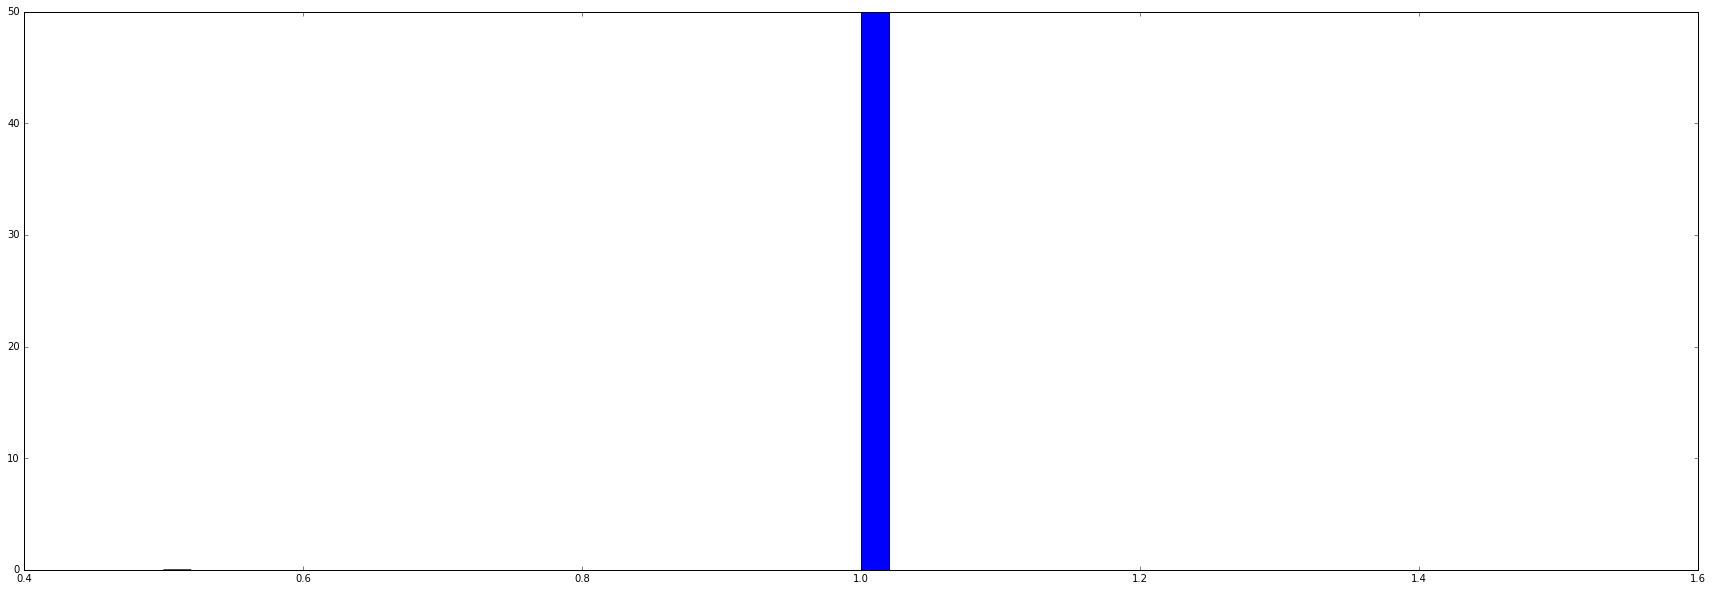

In [17]:
distrib_peak_len(outfile)

**Contains a lot of fields, some of which I don't even have an idea of what the contains. The dataset was not filtered and contains not only A>G A>I transitions. There is a total of 22686 sites but only 21111 are A>G transitions. I filtered out all the other modifications and retained only the A>G transition.**

**I am not sure that I should use this dataset, especially since it is already included in RADAR the RADAR database.**

---
### editing_Sakurai_hg38

In [18]:
infile = "./PTM_Original_Datasets/editing_Sakurai_hg38.bed"
PMID = "24407955"
cell = "Brain"
modification = "A>I"
method = "ICE_seq"
author = "Sakurai"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/editing_Sakurai_hg38.bed
Total lines:	20488

0	# Transcriptome-wide map of editing sites [hg38 coordinates]
1	# Reference: Sakurai et al., Genome Res. 24, 522 (2014) [PMID 24407955, DOI 10.1101/gr.162537.113]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	136167	136168	Sakurai|uc009vjj.1|EST|NA	0	-
7	chr1	136175	136176	Sakurai|uc009vjj.1|EST|NA	0	-
8	chr1	136177	136178	Sakurai|uc009vjj.1|EST|NA	0	-
9	chr1	136178	136179	Sakurai|uc009vjj.1|EST|NA	0	-

20483	chrY	18928288	18928289	Sakurai|NA|No_annotation|SINE/Alu	0	-
20484	chrY	18928298	18928299	Sakurai|NA|No_annotation|SINE/Alu	0	-
20485	chrY	18928299	18928300	Sakurai|NA|No_annotation|SINE/Alu	0	-
20486	chrY	18928319	18928320	Sakurai|NA|No_annotation|SINE/Alu	0	-
20487	chrY	19608866	19608867	Sakurai|NA|No_annotation|SINE/Alu	0	+

|0|chr1|chr19|chr17|chr2|chr7|chr16|chr12|chr15|chr5|chr22|...|
|

In [7]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"|",6,"\t",7,"\t",8]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",7,"\t",8]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

20482 Lines processed	20482 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Sakurai_A>I_Brain_hg38_cleaned.bed
Total lines:	20488

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:20:13.527986
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=A>I|Cell_type=Brain|Analysis_method=ICE_seq|Pubmed_ID=24407955
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	136167	136168	A>I|Brain|ICE_seq|24407955|uc009vjj.1	0	-
7	chr1	136175	136176	A>I|Brain|ICE_seq|24407955|uc009vjj.1	0	-
8	chr1	136177	136178	A>I|Brain|ICE_seq|24407955|uc009vjj.1	0	-
9	chr1	136178	136179	A>I|Brain|ICE_seq|24407955|uc009vjj.1	0	-

20483	chrY	18928288	18928289	A>I|Brain|ICE_seq|24407955|NA	0	-
20484	chrY	18928298	18928299	A>I|Brain|ICE_seq|24407955|NA	0	-
20485	chrY	18928299	18928300	A>I|Brain|ICE_seq|24407955|NA	0	-
20486	chrY	189283

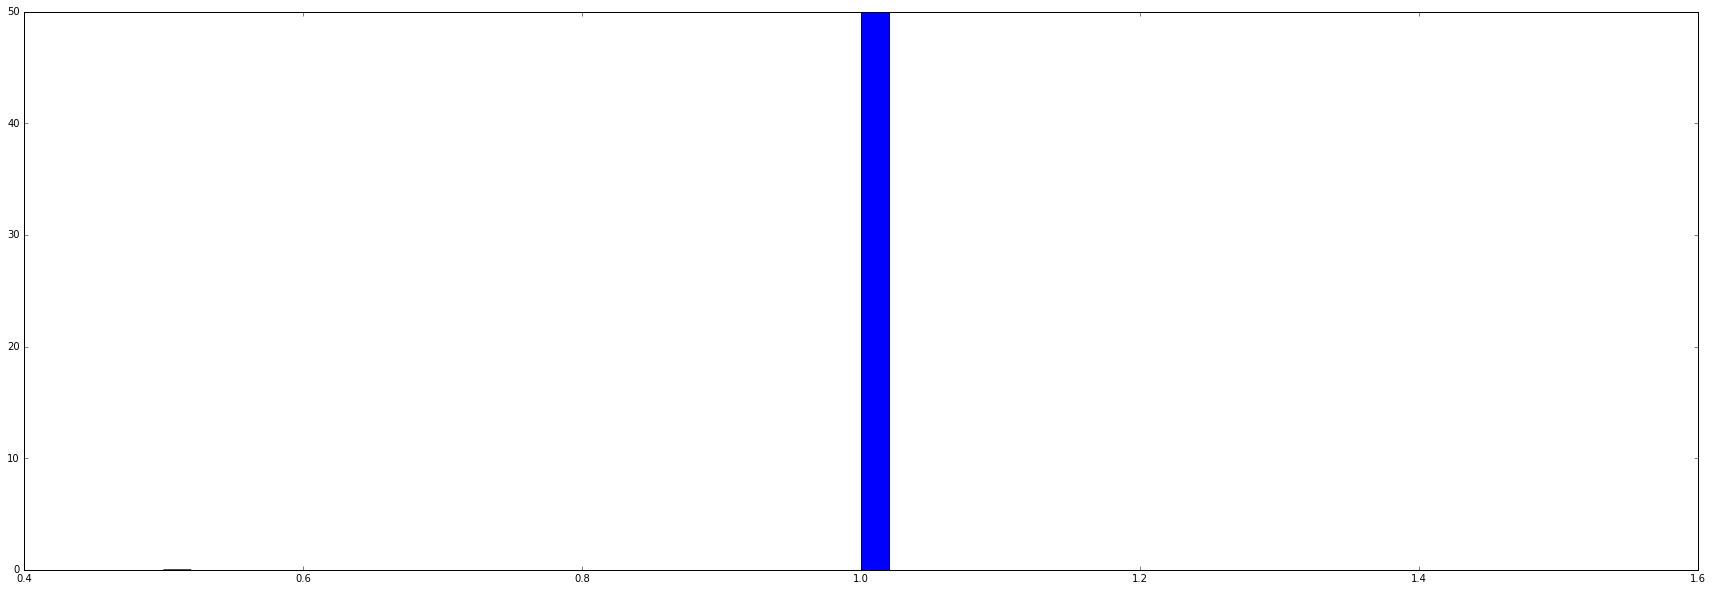

In [19]:
distrib_peak_len(outfile)

**No problem with this dataset, I kept the gene loci name for future comparison after reannotation with GENCODE**

---
### m5C_Hussain_hg38

In [20]:
infile = "./PTM_Original_Datasets/m5C_Hussain_hg38.bed"
PMID = "23871666"
cell = "HEK293"
modification = "m5C"
method = "miCLIP"
author = "Hussain"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/m5C_Hussain_hg38.bed
Total lines:	1090

0	# Transcriptome-wide map of m5C [hg38 coordinates]
1	# Reference: Hussain et al., Genome Biology 14, 215 (2013) [PMID 24286375, DOI 10.1186/gb4143]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	16535295	16535296	Hussain|id102	0	-
7	chr1	16535303	16535304	Hussain|id103	0	-
8	chr1	16535309	16535310	Hussain|id104	0	-
9	chr1	16545955	16545956	Hussain|id105	0	-

1085	chrX	56600603	56600604	Hussain|id1081	0	-
1086	chrX	91280207	91280208	Hussain|id1082	0	+
1087	chrX	121653629	121653630	Hussain|id1075	0	-
1088	chrY	11204085	11204086	Hussain|id1083	0	-
1089	chrY	13552443	13552444	Hussain|id1084	0	-

|0|chr6|chr1|chr5|chr17|chr14|chr16|chr11|chr2|chr8|chr15|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|368|92|88|87|73|59|44|41|39|28|...|

|1|13552443|11204085|121653629|91280207|56600

In [9]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"\t",5,"\t",6]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|-\t",5,"\t",6]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

1084 Lines processed	1084 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Hussain_m5C_HEK293_hg38_cleaned.bed
Total lines:	1090

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:22:11.200389
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m5C|Cell_type=HEK293|Analysis_method=miCLIP|Pubmed_ID=23871666
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	16535295	16535296	m5C|HEK293|miCLIP|23871666|-	0	-
7	chr1	16535303	16535304	m5C|HEK293|miCLIP|23871666|-	0	-
8	chr1	16535309	16535310	m5C|HEK293|miCLIP|23871666|-	0	-
9	chr1	16545955	16545956	m5C|HEK293|miCLIP|23871666|-	0	-

1085	chrX	56600603	56600604	m5C|HEK293|miCLIP|23871666|-	0	-
1086	chrX	91280207	91280208	m5C|HEK293|miCLIP|23871666|-	0	+
1087	chrX	121653629	121653630	m5C|HEK293|miCLIP|23871666|-	0	-
1088	chrY	11204085	11204086	m5C|HEK293|miCL

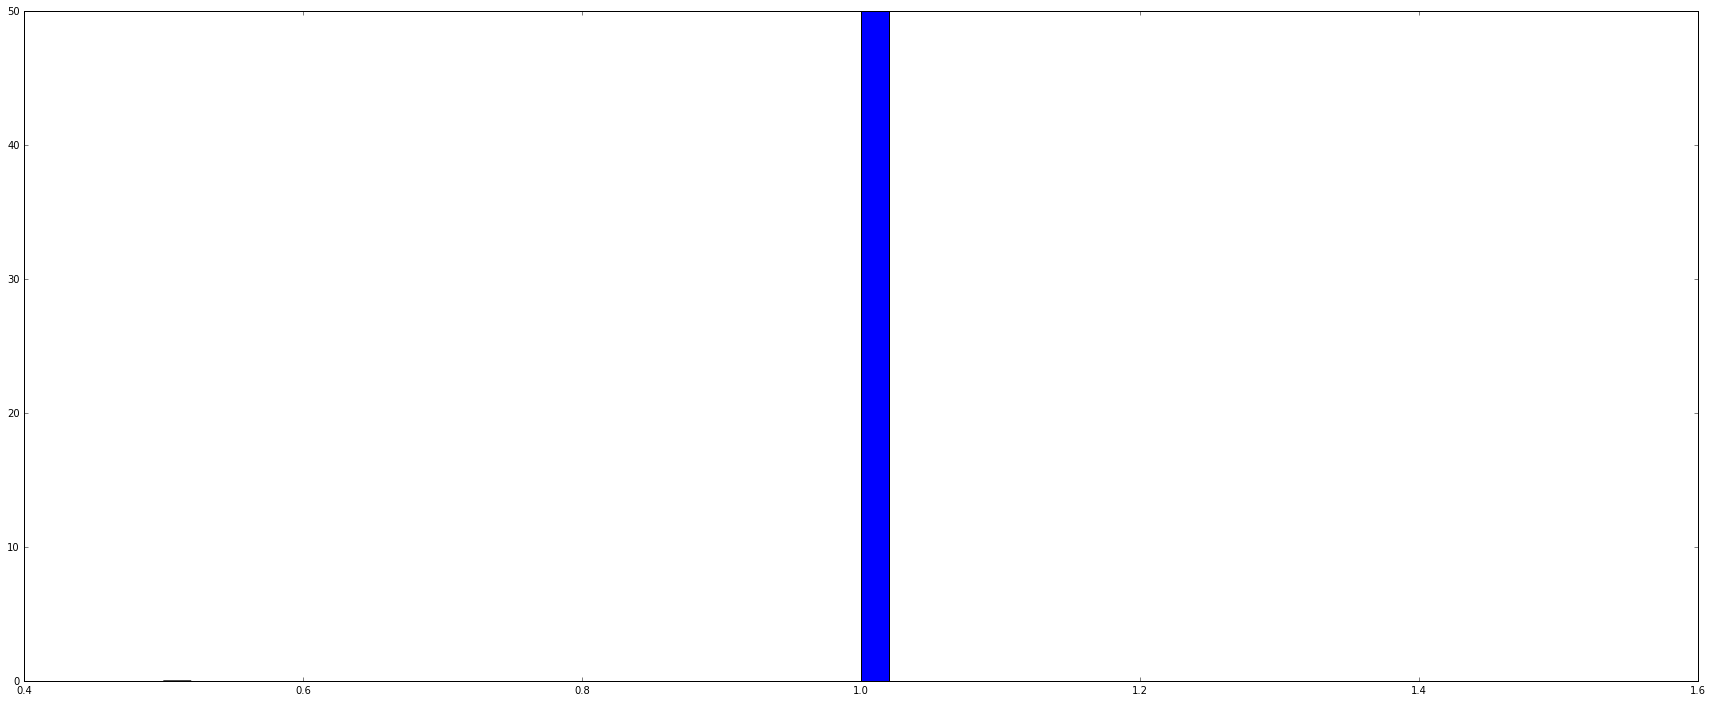

In [13]:
distrib_peak_len(outfile)

**No problem with this dataset, Since there is no gene loci, I just filed the field with a dash to indicate that it is empty**

### m5C_Khoddami_hg38

In [21]:
infile="./PTM_Original_Datasets/m5C_Khoddami_hg38.bed"
PMID = "23604283"
cell = "MEF"
modification = "m5C"
method = "AzaIP"
author = "Khoddami"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/m5C_Khoddami_hg38.bed
Total lines:	20559

0	# Transcriptome-wide map of m5C [hg38 coordinates]
1	# Reference: Khoddami and Cairns, Nat. Biotechnol. 31, 458 (2013) [PMID 23604283, DOI 10.1038/nbt.2566]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	16545917	16545918	Khoddami|tRNA-Gly-GGG	0	-
7	chr1	16545919	16545920	Khoddami|tRNA-Gly-GGG	0	-
8	chr1	16545920	16545921	Khoddami|tRNA-Gly-GGG	0	-
9	chr1	16545921	16545922	Khoddami|tRNA-Gly-GGG	0	-

20554	chrY	3367777	3367778	Khoddami|tRNA-Glu-GAG	0	+
20555	chrY	3367784	3367785	Khoddami|tRNA-Glu-GAG	0	+
20556	chrY	3367799	3367800	Khoddami|tRNA-Glu-GAG	0	+
20557	chrY	3367804	3367805	Khoddami|tRNA-Glu-GAG	0	+
20558	chrY	3367808	3367809	Khoddami|tRNA-Glu-GAG	0	+

|0|chr15|chr6|chr1|chr17|chr16|chr14|chr5|chr12|chr7|chr3|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|5959|3648|1

In [11]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"\t",5,"\t",6]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",5,"\t",6]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

20553 Lines processed	20553 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Khoddami_m5C_MEF_hg38_cleaned.bed
Total lines:	20559

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:22:52.164144
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m5C|Cell_type=MEF|Analysis_method=AzaIP|Pubmed_ID=23604283
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	16545917	16545918	m5C|MEF|AzaIP|23604283|tRNA-Gly-GGG	0	-
7	chr1	16545919	16545920	m5C|MEF|AzaIP|23604283|tRNA-Gly-GGG	0	-
8	chr1	16545920	16545921	m5C|MEF|AzaIP|23604283|tRNA-Gly-GGG	0	-
9	chr1	16545921	16545922	m5C|MEF|AzaIP|23604283|tRNA-Gly-GGG	0	-

20554	chrY	3367777	3367778	m5C|MEF|AzaIP|23604283|tRNA-Glu-GAG	0	+
20555	chrY	3367784	3367785	m5C|MEF|AzaIP|23604283|tRNA-Glu-GAG	0	+
20556	chrY	3367799	3367800	m5C|MEF|AzaIP|23604283|tRNA-Glu-GAG	0	+
20

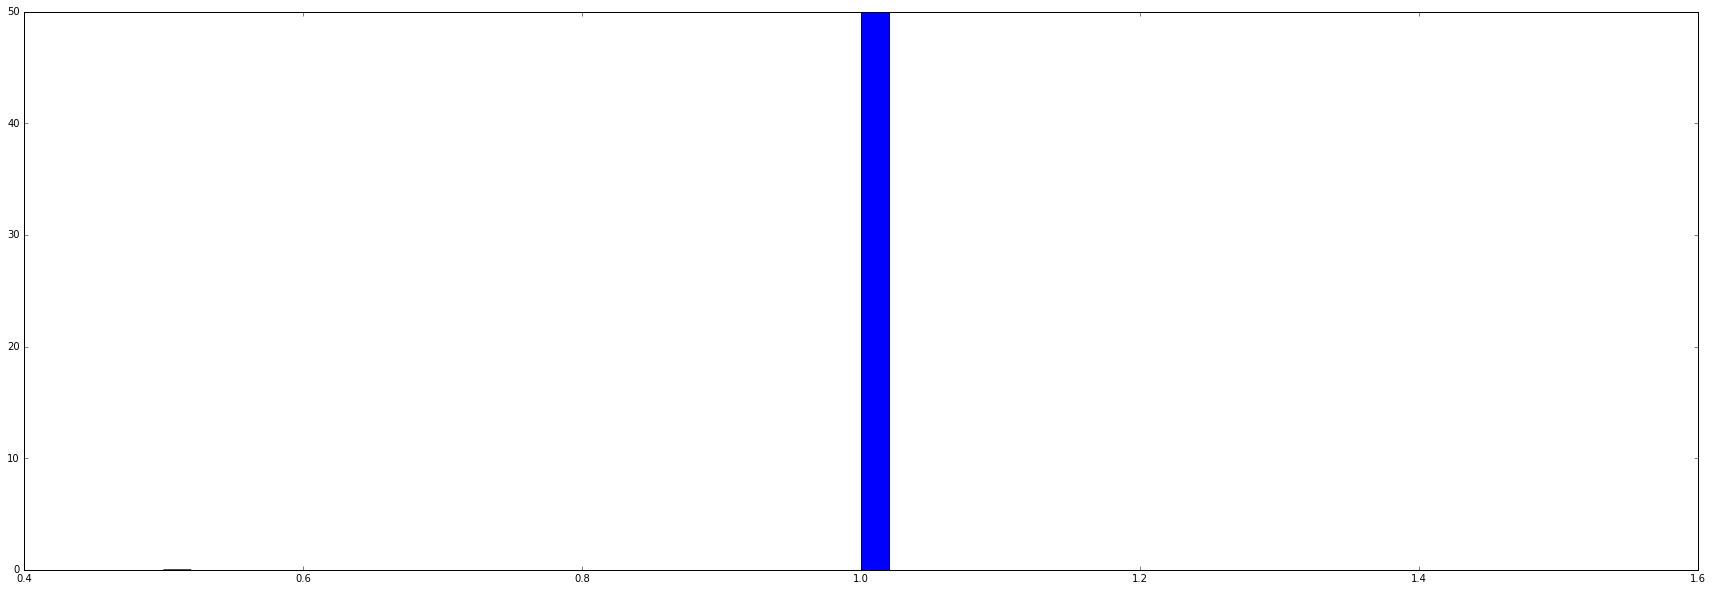

In [22]:
distrib_peak_len(outfile)

**No problem with this dataset. It seems to be focussed on tRNA gene that are clearly over-represented in the gene list**

---
### m5C_Squires_hg38

In [23]:
infile="./PTM_Original_Datasets/m5C_Squires_hg38.bed"
PMID = "22344696"
cell = "HeLa"
modification = "m5C"
method = "bisulfite_seq"
author = "Squires"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/m5C_Squires_hg38.bed
Total lines:	10496

0	# Transcriptome-wide map of m5C [hg38 coordinates]
1	# Reference: Squires et al., Nucleic Acids Res. 40, 5023 (2012) [PMID 22344696, DOI 10.1093/nar/gks144]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	631539	631540	Squires|id1	0	+
7	chr1	631540	631541	Squires|id2	0	+
8	chr1	632285	632286	Squires|id3	0	+
9	chr1	632286	632287	Squires|id4	0	+

10491	chrX	155291091	155291092	Squires|id10271	0	-
10492	chrX	156023069	156023070	Squires|id10272	0	+
10493	chrY	5105140	5105141	Squires|id10273	0	+
10494	chrY	5338229	5338230	Squires|id10274	0	-
10495	chrY	10192049	10192050	Squires|id10275	0	-

|0|chr1|chr17|chr19|chr11|chr3|chr6|chr2|chr5|chr12|chr7|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|1169|734|660|659|621|608|582|576|497|472|...|

|1|1629420|1629419|10192049|5338229|510514

In [13]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"\t",5,"\t",6]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|-\t",5,"\t",6]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

10490 Lines processed	10490 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Squires_m5C_HeLa_hg38_cleaned.bed
Total lines:	10496

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:23:48.676446
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m5C|Cell_type=HeLa|Analysis_method=bisulfite_seq|Pubmed_ID=22344696
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	631539	631540	m5C|HeLa|bisulfite_seq|22344696|-	0	+
7	chr1	631540	631541	m5C|HeLa|bisulfite_seq|22344696|-	0	+
8	chr1	632285	632286	m5C|HeLa|bisulfite_seq|22344696|-	0	+
9	chr1	632286	632287	m5C|HeLa|bisulfite_seq|22344696|-	0	+

10491	chrX	155291091	155291092	m5C|HeLa|bisulfite_seq|22344696|-	0	-
10492	chrX	156023069	156023070	m5C|HeLa|bisulfite_seq|22344696|-	0	+
10493	chrY	5105140	5105141	m5C|HeLa|bisulfite_seq|22344696|-	0	+
10494	chrY	5338

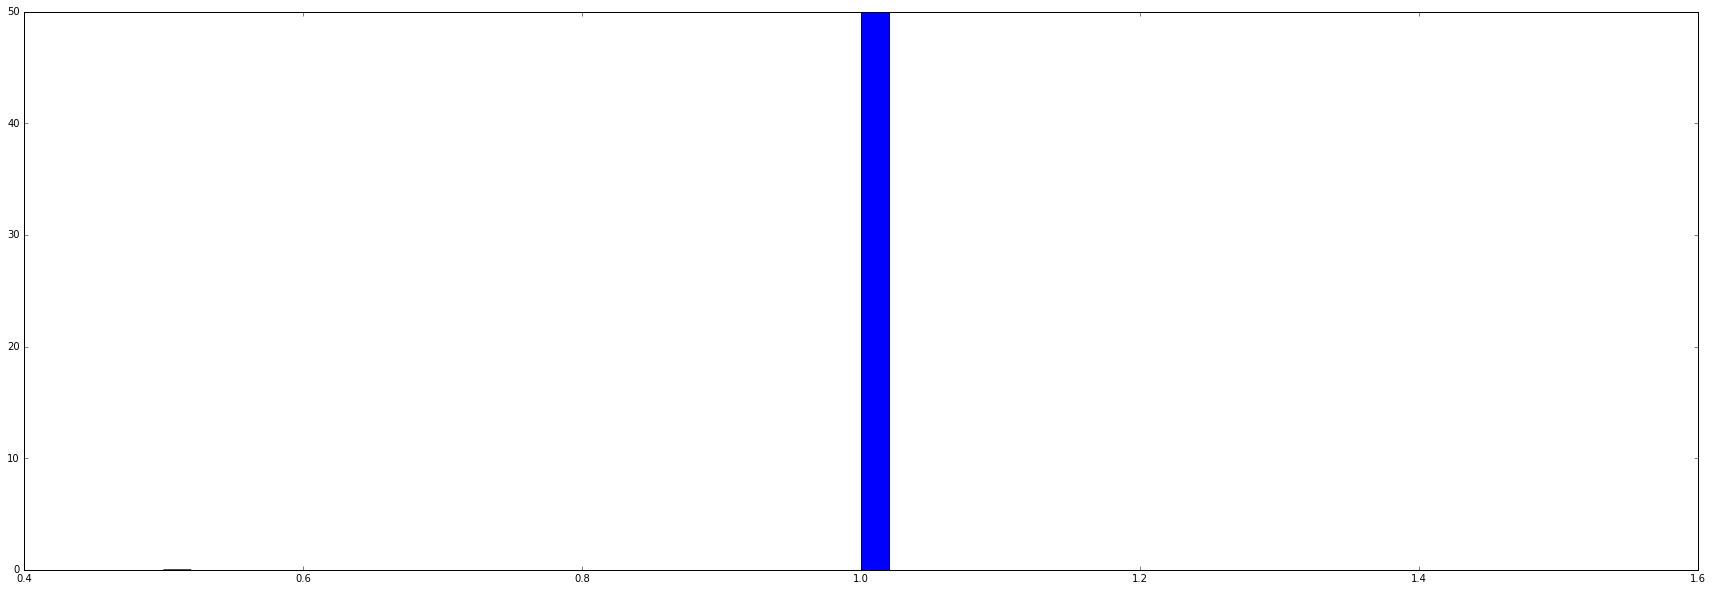

In [24]:
distrib_peak_len(outfile)

**1 nt wide peaks = No problem with this dataset. Since there are no gene loci, I just filed the field with a dash to indicate that it is empty**

---
### m6A_Dominissini_hg38

In [25]:
infile="./PTM_Original_Datasets/m6A_Dominissini_hg38.bed"
PMID = "22575960"
cell = "HepG2"
modification = "m6A"
method = "M6A_seq"
author = "Dominissini"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/m6A_Dominissini_hg38.bed
Total lines:	25782

0	# Transcriptome-wide map of m6A [hg38 coordinates]
1	# Reference: Dominissini et al., Nature 485, 201 (2012) [PMID 22575960, DOI 10.1038/nature11112]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	10000	10156	Dominissini|NR_003285|NR_003285	0	+
7	chr1	10000	12006	Dominissini|NR_003286|NR_003286	0	+
8	chr1	10000	15207	Dominissini|NR_003287|NR_003287	0	+
9	chr1	14405	29358	Dominissini|FLJ00038|iduc009viw.1	0	-

25777	chrY	25975511	25988101	Dominissini|PRY|iduc004fxh.1	0	+
25778	chrY	56954307	56968975	Dominissini|SPRY3|iduc004fxi.1	0	+
25779	chrY	57067874	57130276	Dominissini|VAMP7|iduc004fxj.1	0	+
25780	chrY	57184099	57197337	Dominissini|IL9R|iduc004fxn.1	0	+
25781	chrY	57208832	57212183	Dominissini|WASH1|iduc010nxs.1	0	+

|0|chr1|chr19|chr2|chr11|chr17|chr6|chr15|chr3|chr7|chr12|...|
|:---|:---|:--

In [15]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"\t",6,"\t",7]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",6,"\t",7]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

25776 Lines processed	25776 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Dominissini_m6A_HepG2_hg38_cleaned.bed
Total lines:	25782

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:24:50.200866
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m6A|Cell_type=HepG2|Analysis_method=M6A_seq|Pubmed_ID=22575960
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	10000	10156	m6A|HepG2|M6A_seq|22575960|NR_003285	0	+
7	chr1	10000	12006	m6A|HepG2|M6A_seq|22575960|NR_003286	0	+
8	chr1	10000	15207	m6A|HepG2|M6A_seq|22575960|NR_003287	0	+
9	chr1	14405	29358	m6A|HepG2|M6A_seq|22575960|FLJ00038	0	-

25777	chrY	25975511	25988101	m6A|HepG2|M6A_seq|22575960|PRY	0	+
25778	chrY	56954307	56968975	m6A|HepG2|M6A_seq|22575960|SPRY3	0	+
25779	chrY	57067874	57130276	m6A|HepG2|M6A_seq|22575960|VAMP7	0	+
25780	chrY	57184099

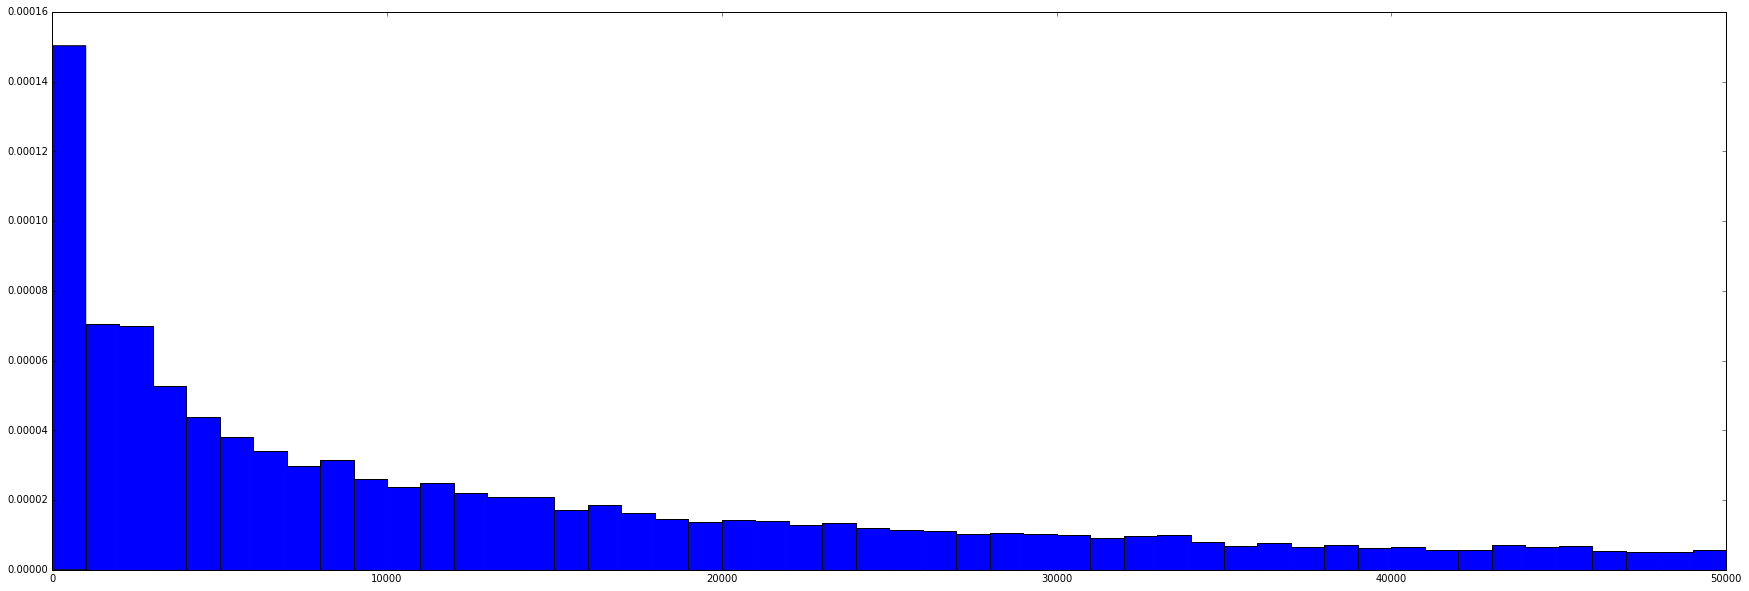

In [26]:
distrib_peak_len(outfile,range=[0,50000])

**The original dataset seems to be OK, but the width of some peaks could be huge (see figure above). I don't know if this is normal or not. This is gonna be hard to attribute a uniq and precise gene feature. Maybe I should remove the very large peaks ??? Is it the coordinates of the genes instead of the peaks? Yes apparently The author of the review did not find the peak coordinates and infered them from the gene names instead. Is the dataset useable ???**

---
### m6A_Meyer_hg38

In [18]:
infile="./PTM_Original_Datasets/m6A_Meyer_hg38.bed"
PMID = "22608085"
cell = "HEK293"
modification = "m6A"
method = "MeRIP_Seq"
author = "Meyer"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./Shafik_RNA-PTM/m6A_Meyer_hg38.bed
Total lines:	4347

0	# Transcriptome-wide map of m6A [hg38 coordinates]
1	# Reference: Meyer et al., Cell 149, 1635 (2012) [PMID 22608085, DOI 10.1016/j.cell.2012.05.003]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	1055019	1055133	Meyer|AGRN|3'UTR	0	+
7	chr1	1055132	1055245	Meyer|AGRN|3'UTR	0	+
8	chr1	1055419	1055620	Meyer|AGRN|3'UTR	0	+
9	chr1	1232619	1232795	Meyer|B3GALT6|CDS	0	+

4342	chrX	154488410	154488595	Meyer|SLC10A3|CDS	0	-
4343	chrX	154488594	154488779	Meyer|SLC10A3|CDS	0	-
4344	chrX	154488778	154488961	Meyer|SLC10A3|Exon	0	-
4345	chrX	155216447	155216548	Meyer|VBP1|Exon	0	+
4346	chrX	155260564	155260740	Meyer|RAB39B|3'UTR	0	-

Found 8 colums
First line found
|0|chr1|chr3|chr2|chr16|chr6|chrX|chr17|chr5|chr8|chr12|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|364|269|262|240|233|232|229|221

In [19]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"\t",6,"\t",7]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",6,"\t",7]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

4341 Lines processed	4341 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Meyer_m6A_HEK293_hg38_cleaned.bed
Total lines:	4347

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:26:55.702614
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m6A|Cell_type=HEK293|Analysis_method=MeRIP_Seq|Pubmed_ID=22608085
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	1055019	1055133	m6A|HEK293|MeRIP_Seq|22608085|AGRN	0	+
7	chr1	1055132	1055245	m6A|HEK293|MeRIP_Seq|22608085|AGRN	0	+
8	chr1	1055419	1055620	m6A|HEK293|MeRIP_Seq|22608085|AGRN	0	+
9	chr1	1232619	1232795	m6A|HEK293|MeRIP_Seq|22608085|B3GALT6	0	+

4342	chrX	154488410	154488595	m6A|HEK293|MeRIP_Seq|22608085|SLC10A3	0	-
4343	chrX	154488594	154488779	m6A|HEK293|MeRIP_Seq|22608085|SLC10A3	0	-
4344	chrX	154488778	154488961	m6A|HEK293|MeRIP_Seq|22608085|SLC1

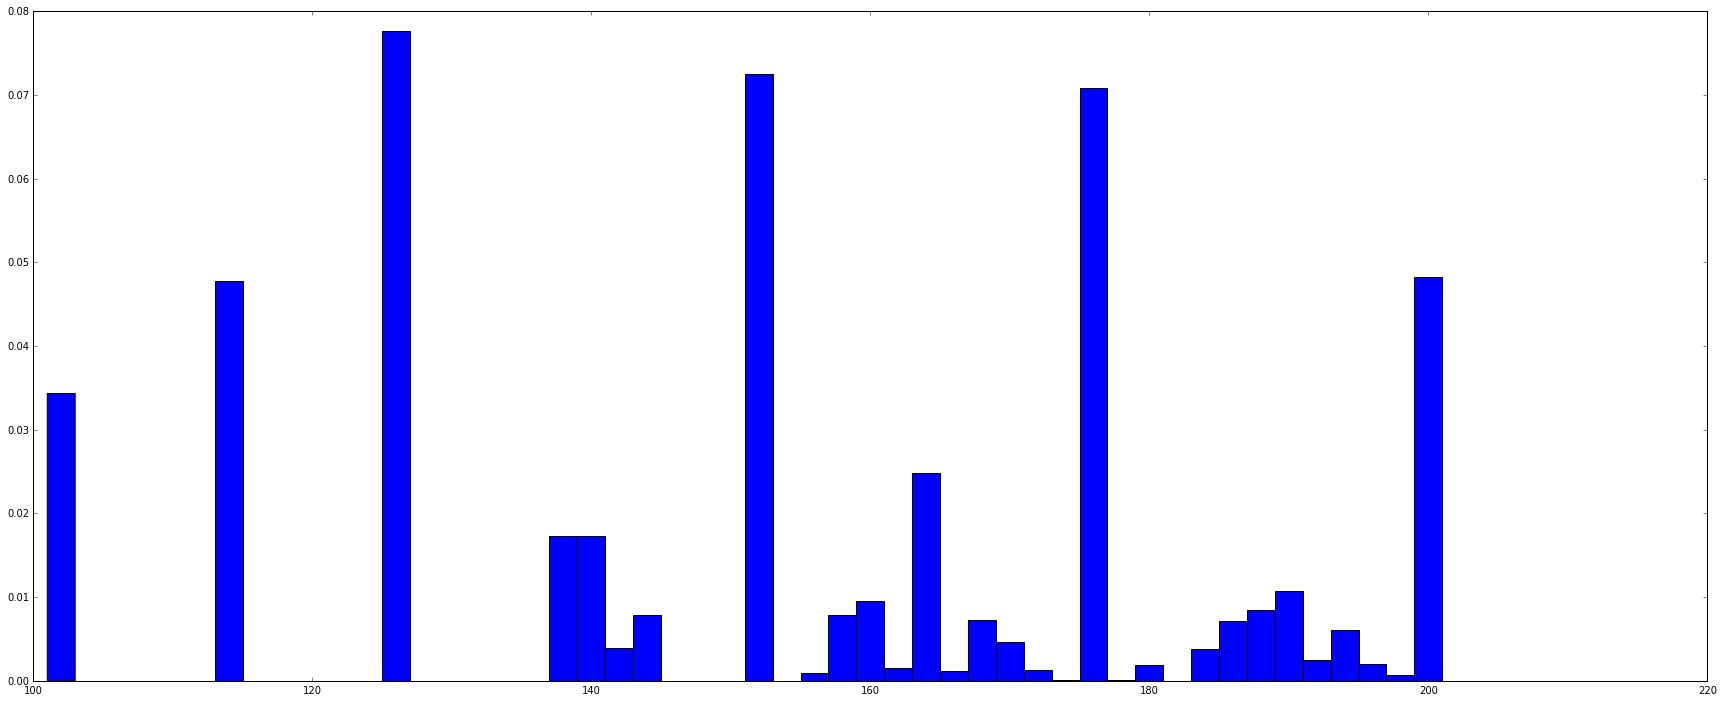

In [20]:
distrib_peak_len(outfile)

**The original dataset was OK and clean. Contrary to the previous dataset the width of the peaks are between 100 and 200 pb wich is clearly better** 

---
### miCLIP_m6A_Linder2015_hg38

In [27]:
infile="./PTM_Original_Datasets/miCLIP_m6A_Linder2015_hg38.bed"
PMID = "26121403"
cell = "HEK293"
modification = "m6A:m6Am"
method = "miCLIP"
author = "Linder"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/miCLIP_m6A_Linder2015_hg38.bed
Total lines:	15174

0	# miCLIP-based transcriptome-wide map of m6A and m6Am sites [hg38 coordinates]
1	# Reference: Linder et al., Nat. Methods 12, 767 (2015) [PMID 26121403, DOI 10.1038/nmeth.3453]
2	# Data converted to BED from Supplementary tables S2 and S3, conversion to hg38 using liftOver.
3	#
4	# Data is part of the R package RNAModR
5	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
6	#
7	chr1	631479	631480	B045_1-4_chr1_f_c1[k=4][m=2]_CTACT;MIR6723;hsa-mir-6723;microRNAmir-6723	1	+
8	chr1	634538	634539	B045_1-4_chr1_f_c5[k=52][m=2]_ATACC;MIR6723;hsa-mir-6723;microRNAmir-6723	1	+
9	chr1	931395	931396	B045_1-4_chr1_f_c7[k=4][m=2]_AGACT;XM_005244723;ENSG00000187634;SAMD11	1	+

15169	chrX	154516231	154516232	105216[gene=chrX_r_c40520][PH=3][PH0=0.06][P=1.02e-02]_CCATT;XM_005274713;ENSG00000071889;FAM3A	1	-
15170	chrX	155071078	155071079	105658[gene=chrX_r_c40716][PH=3][PH0=0.12][P=2.81e-02]_CCATT;NM_001018024;E

In [22]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"\t",4,"\t",5]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|-\t",4,"\t",5]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

15167 Lines processed	15167 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Linder_m6A:m6Am_HEK293_hg38_cleaned.bed
Total lines:	15173

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:27:58.239000
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m6A:m6Am|Cell_type=HEK293|Analysis_method=miCLIP|Pubmed_ID=26121403
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	631479	631480	m6A:m6Am|HEK293|miCLIP|26121403|-	1	+
7	chr1	634538	634539	m6A:m6Am|HEK293|miCLIP|26121403|-	1	+
8	chr1	931395	931396	m6A:m6Am|HEK293|miCLIP|26121403|-	1	+
9	chr1	942770	942771	m6A:m6Am|HEK293|miCLIP|26121403|-	2	+

15168	chrX	154516231	154516232	m6A:m6Am|HEK293|miCLIP|26121403|-	1	-
15169	chrX	155071078	155071079	m6A:m6Am|HEK293|miCLIP|26121403|-	1	-
15170	chrY	10195941	10195942	m6A:m6Am|HEK293|miCLIP|26121403|-	1	+
15171	c

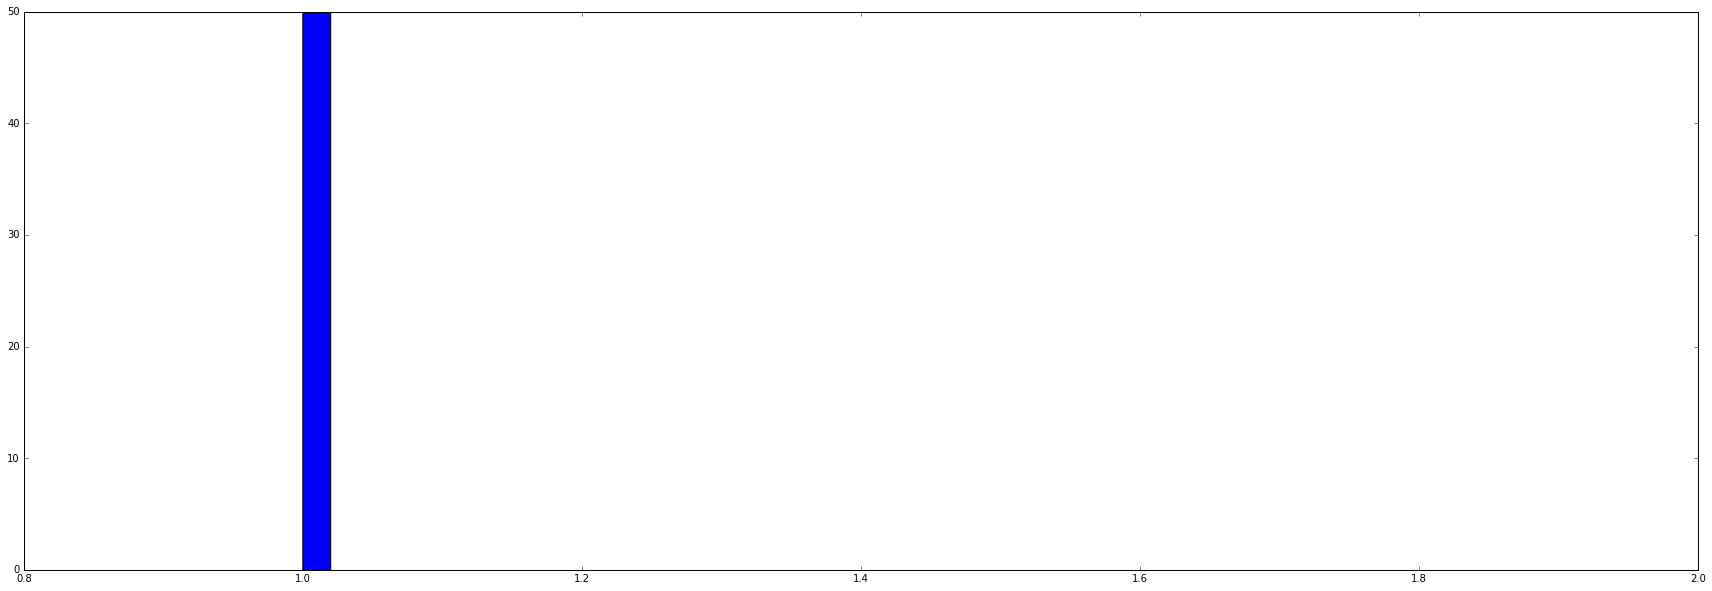

In [28]:
distrib_peak_len(outfile)

**The name field is unusable since it contains a random number of fieds... I cannot parse it easily. That is not a big problem since I will reannotate the data based on the last gencode annotation realease, I did not save any of the informations contained in the original name field. With miCLIP data the peak are 1 nt wide**

---
### MeRIPseq_m1A_Dominissini2016_hg38

In [29]:
infile="./PTM_Original_Datasets/MeRIPseq_m1A_Dominissini2016_hg38.bed"
PMID = "26863196"
cell = "HeLa:HEK293:HepG2"
modification = "m1A"
method = "M1A_seq"
author = "Dominissini"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/MeRIPseq_m1A_Dominissini2016_hg38.bed
Total lines:	32136

0	# MeRIP-seq-based transcriptome-wide map of m1A [hg38 coordinates]
1	# Reference: Dominissini et al., Nature 530, 441 (2016) [PMID 26863196, DOI 10.1038/nature16998]
2	# Data converted to BED from Supplementary table 1, conversion to hg38 using liftOver.
3	# Strand information is missing in original reference, and was added using current
4	# RefSeq annotation from NCBI and UCSC.
5	#
6	# Data is part of the R package RNAModR
7	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
8	#
9	chr1	17001	17002	NR_024540|ncRNA|HeLa	0	-

32131	chrX	155216522	155216523	NM_001303545|5UTR|HEPG2_common_mRNA	0	+
32132	chrX	155216526	155216527	NM_003372|CDS|HeLa	0	+
32133	chrX	155612852	155612853	NM_001184797|5UTR|HEPG2_common_mRNA	0	-
32134	chrX	155612855	155612856	NM_001184797|5UTR|HeLa	0	-
32135	chrX	155612864	155612865	NM_001184797|5UTR|HEPG2_Glucose_starv_4h	0	-

|0|chr1|chr19|chr17|chr16|chr2|chr11|chr1

**I don't know understand some of the categories for HEPG2 cells**
* Hela = No ambiguity 
* HEK293 = No ambiguity
* HEPG2_common_mRNA = Unclear, but aparently looking at the data this is the general RNA dataset (including ncRNA) after peak calling in untreated HEPG2 cells  
* HEPG2_heat_shock_4h = No ambiguity
* HEPG2_Glucose_starv_4h = No ambiguity
* HEPG2_common_total_RNA = Unclear, but it seems to be commons peaks shared by all the cell types.

In [37]:
###### chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"\t",6,"\t",7]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",5,"|",method,"|",PMID,"|",3,"\t",6,"\t",7]

# filter out all but A>G transition which are Inosine transition
filter_dict={5:["HEPG2_heat_shock_4h","HEPG2_Glucose_starv_4h","HEPG2_common_total_RNA"]}

# Reformat the field value A->G to A>I for standardization 
subst_dict={5:{"HEPG2_common_mRNA":"HepG2"}}

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-",
    subst_dict = subst_dict,
    filter_dict = filter_dict
    )

file_summary(outfile)

32127 Lines processed	19552 Lines pass	12575 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Dominissini_m1A_HeLa:HEK293:HepG2_hg38_cleaned.bed
Total lines:	19558

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 14:27:18.116524
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m1A|Cell_type=HeLa:HEK293:HepG2|Analysis_method=M1A_seq|Pubmed_ID=26863196
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	17001	17002	m1A|HeLa|M1A_seq|26863196|NR_024540	0	-
7	chr1	24826	24827	m1A|HeLa|M1A_seq|26863196|NR_024540	0	-
8	chr1	778484	778485	m1A|HepG2|M1A_seq|26863196|NR_033908	0	-
9	chr1	826715	826716	m1A|HeLa|M1A_seq|26863196|NR_024321	0	-

19553	chrX	155071584	155071585	m1A|HEK293|M1A_seq|26863196|NM_001018055	0	+
19554	chrX	155216522	155216523	m1A|HepG2|M1A_seq|26863196|NM_001303545	0	+
19555	chrX	155216526	155216527	m1A

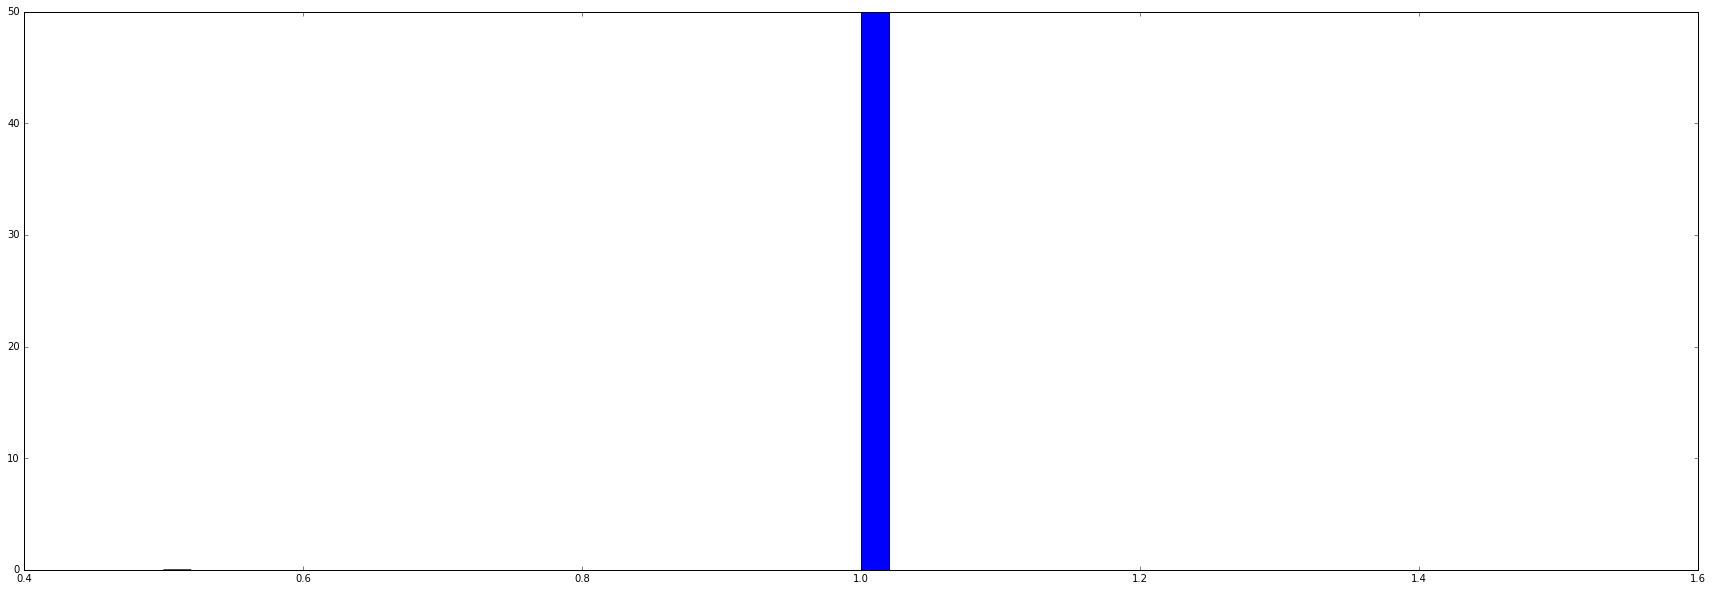

In [30]:
distrib_peak_len(outfile)

---
### pseudoU_Carlile_hg38

In [31]:
infile="./PTM_Original_Datasets/pseudoU_Carlile_hg38.bed"
PMID = "25192136"
cell = "HeLa"
modification = "Y"
method = "Pseudo_seq"
author = "Carlile"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/pseudoU_Carlile_hg38.bed
Total lines:	14

0	# Transcriptome-wide map of pseudouridine [hg38 coordinates]
1	# Reference: Carlile et al., Nature 515, 143 (2014) [PMID 25192136, DOI 10.1038/nature13802]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr11	62851987	62855914	ENST00000538654|SNHG1	1766	-
7	chr11	65497761	65506469	ENST00000534336|MALAT1	5160	+
8	chr11	65497761	65506469	ENST00000534336|MALAT1	5590	+
9	chr12	98599634	98599883	ENST00000391141|SNORA53	110	+

9	chr12	98599634	98599883	ENST00000391141|SNORA53	110	+
10	chr17	16438821	16478678	ENST00000497774|FAM211A-AS1	1537	+
11	chr2	231455799	231455936	ENST00000384158|SNROA75	84	-
12	chr6	52995619	52995950	ENST00000365328|RN7SK	250	+
13	chrX	119787352	119787484	ENST00000383895|SNORA69	81	-

|0|chr11|chrX|chr6|chr2|chr17|chr12|
|:---|:---|:---|:---|:---|:---|:---|
|Count|3|1|1|1|1|1|

|1|654977

In [32]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"\t",5,"\t",6]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",5,"\t",6]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

8 Lines processed	8 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Carlile_Y_HeLa_hg38_cleaned.bed
Total lines:	14

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 14:23:30.530422
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=Y|Cell_type=HeLa|Analysis_method=Pseudo_seq|Pubmed_ID=25192136
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr11	62851987	62855914	Y|HeLa|Pseudo_seq|25192136|SNHG1	1766	-
7	chr11	65497761	65506469	Y|HeLa|Pseudo_seq|25192136|MALAT1	5160	+
8	chr11	65497761	65506469	Y|HeLa|Pseudo_seq|25192136|MALAT1	5590	+
9	chr12	98599634	98599883	Y|HeLa|Pseudo_seq|25192136|SNORA53	110	+

9	chr12	98599634	98599883	Y|HeLa|Pseudo_seq|25192136|SNORA53	110	+
10	chr17	16438821	16478678	Y|HeLa|Pseudo_seq|25192136|FAM211A-AS1	1537	+
11	chr2	231455799	231455936	Y|HeLa|Pseudo_seq|25192136|SNROA75	84

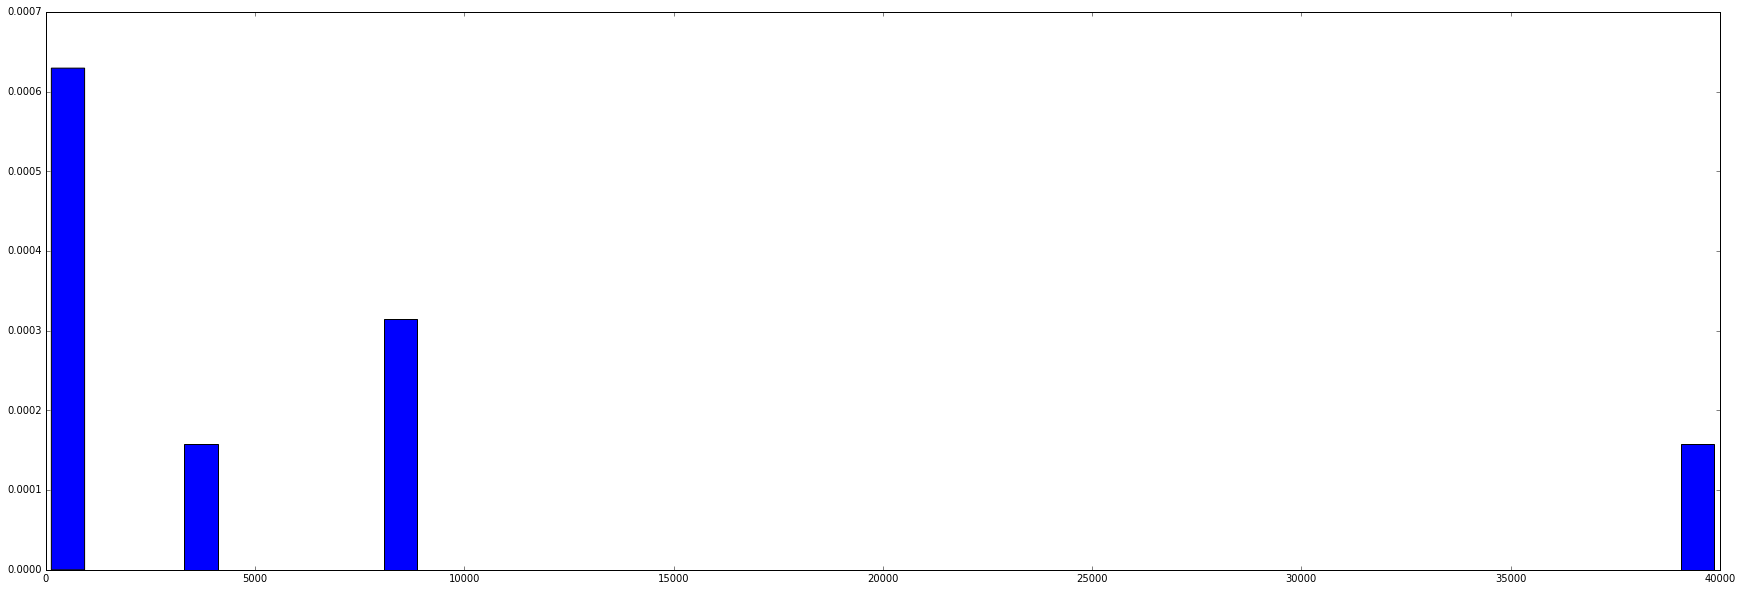

In [32]:
distrib_peak_len(outfile)

**Dataset OK but only contains only 8 peaks in lncRNA. 1 of the peaks is really wide = 40000 pb The dataset contains only the 8 peaks identify in the lncRNA... The coordinates correspond to the gen coordinates rather than the peaks themselves.. Use the dataset??** 

### pseudoU_Li_hg38

In [33]:
infile="./PTM_Original_Datasets/pseudoU_Li_hg38.bed"
PMID = "26075521"
cell = "HEK293"
modification = "Y"
method = "CeU_Seq"
author = "Li"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/pseudoU_Li_hg38.bed
Total lines:	1495

0	# Transcriptome-wide map of pseudouridine [hg38 coordinates]
1	# Reference: Li et al., Nat. Chem. Biol. 11, 592 (2015) [PMID 26075521, DOI 10.1038/nchembio.1836]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	1051520	1051521	Li|AGRN|NM_198576|CDS	0	+
7	chr1	1254956	1254957	Li|UBE2J2|NM_194458|3'_UTR	0	-
8	chr1	1298603	1298604	Li|ACAP3|NM_030649|CDS	0	-
9	chr1	1386884	1386885	Li|CCNL2|NM_030937|3'_UTR	0	-

1490	chrX	154765960	154765961	Li|DKC1|NR_110022|noncoding	0	+
1491	chrX	155033408	155033409	Li|FUNDC2|NM_023934|CDS	0	+
1492	chrX	155054648	155054649	Li|FUNDC2|NM_023934|CDS	0	+
1493	chrX	155122200	155122201	Li|BRCC3|NM_024332|3'_UTR	0	+
1494	chrX	155258757	155258758	Li|RAB39B|NM_171998|3'_UTR	0	-

|0|chr1|chr17|chr19|chr11|chr2|chr12|chr3|chrX|chr16|chr6|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:

In [35]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"|",6,"\t",7,"\t",8]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",7,"\t",8]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

1489 Lines processed	1489 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Li_Y_HEK293_hg38_cleaned.bed
Total lines:	1495

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 14:26:25.480994
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=Y|Cell_type=HEK293|Analysis_method=CeU_Seq|Pubmed_ID=26075521
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	1051520	1051521	Y|HEK293|CeU_Seq|26075521|AGRN	0	+
7	chr1	1254956	1254957	Y|HEK293|CeU_Seq|26075521|UBE2J2	0	-
8	chr1	1298603	1298604	Y|HEK293|CeU_Seq|26075521|ACAP3	0	-
9	chr1	1386884	1386885	Y|HEK293|CeU_Seq|26075521|CCNL2	0	-

1490	chrX	154765960	154765961	Y|HEK293|CeU_Seq|26075521|DKC1	0	+
1491	chrX	155033408	155033409	Y|HEK293|CeU_Seq|26075521|FUNDC2	0	+
1492	chrX	155054648	155054649	Y|HEK293|CeU_Seq|26075521|FUNDC2	0	+
1493	chrX	155122200	155122201	Y|H

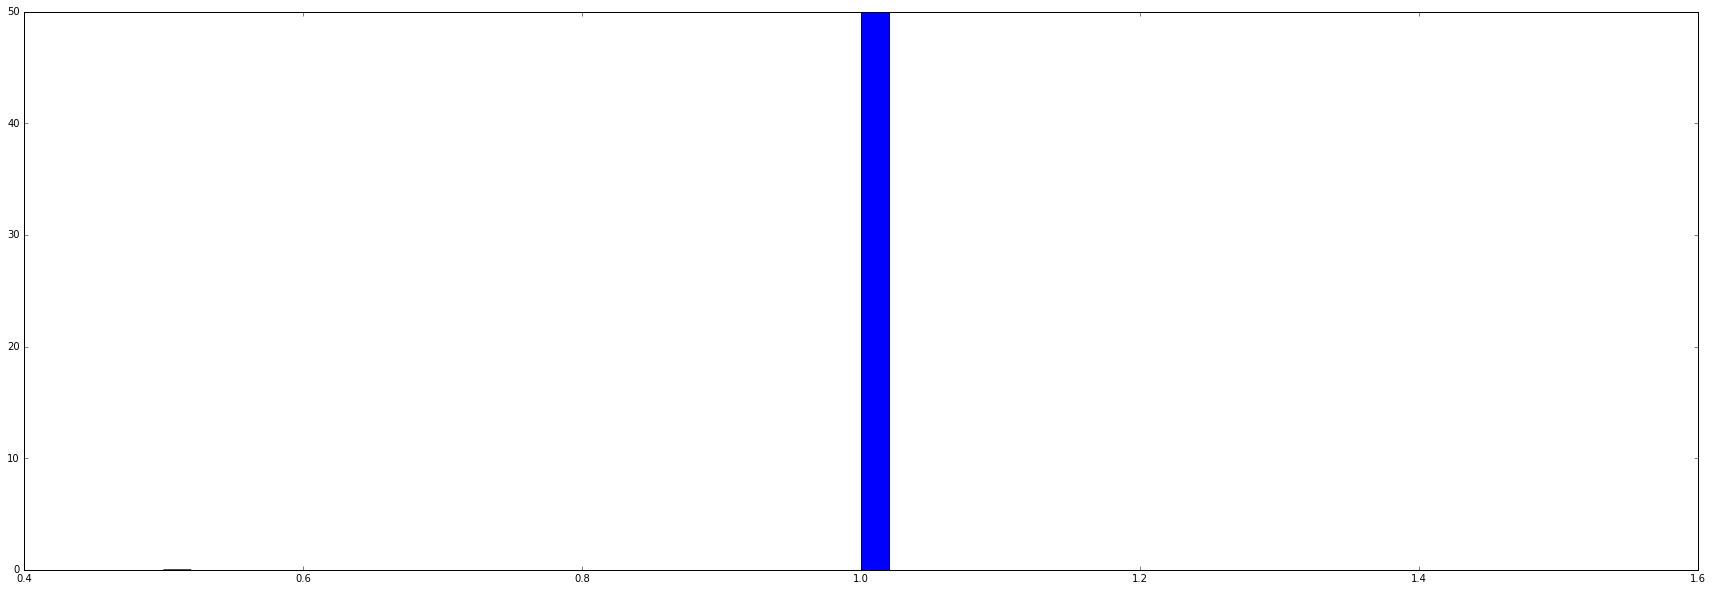

In [34]:
distrib_peak_len(outfile)

**No problem with this dataset**

### pseudoU_Schwartz_hg38

In [35]:
infile="./PTM_Original_Datasets/pseudoU_Schwartz_hg38.bed"
PMID = "25219674"
cell = "HEK293:Fibroblast"
modification = "Y"
method = "Psi-seq"
author = "Schwartz"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/pseudoU_Schwartz_hg38.bed
Total lines:	402

0	# Transcriptome-wide map of pseudouridine [hg38 coordinates]
1	# Reference: Schwartz et al., Cell 159, 148 (2014) [PMID 25219674, DOI 10.1016/j.cell.2014.08.028]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	1045799	1045800	Schwartz|AGRN	0	+
7	chr1	6222864	6222865	Schwartz|ICMT	0	-
8	chr1	6623606	6623607	Schwartz|PHF13	0	+
9	chr1	16545956	16545957	Schwartz|TRNA_Gly	0	-

397	chrX	136210827	136210828	Schwartz|FHL1	0	+
398	chrX	153694609	153694610	Schwartz|SLC6A8	0	+
399	chrX	153700577	153700578	Schwartz|BCAP31	0	-
400	chrX	153786900	153786901	Schwartz|IDH3G	0	-
401	chrX	154765960	154765961	Schwartz|DKC1	0	+

|0|chr1|chr12|chr2|chr5|chr17|chr11|chr6|chr3|chrX|chr8|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|58|30|28|27|25|24|23|22|18|18|...|

|1|23917850|22829934|1547659

In [39]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"\t",5,"\t",6]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",5,"\t",6]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

396 Lines processed	396 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Schwartz_Y_HEK293:Fibroblast_hg38_cleaned.bed
Total lines:	402

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 14:30:59.408427
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=Y|Cell_type=HEK293:Fibroblast|Analysis_method=Psi-seq|Pubmed_ID=25219674
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	1045799	1045800	Y|HEK293:Fibroblast|Psi-seq|25219674|AGRN	0	+
7	chr1	6222864	6222865	Y|HEK293:Fibroblast|Psi-seq|25219674|ICMT	0	-
8	chr1	6623606	6623607	Y|HEK293:Fibroblast|Psi-seq|25219674|PHF13	0	+
9	chr1	16545956	16545957	Y|HEK293:Fibroblast|Psi-seq|25219674|TRNA_Gly	0	-

397	chrX	136210827	136210828	Y|HEK293:Fibroblast|Psi-seq|25219674|FHL1	0	+
398	chrX	153694609	153694610	Y|HEK293:Fibroblast|Psi-seq|25219674|SLC6A8	0	+
399	chrX

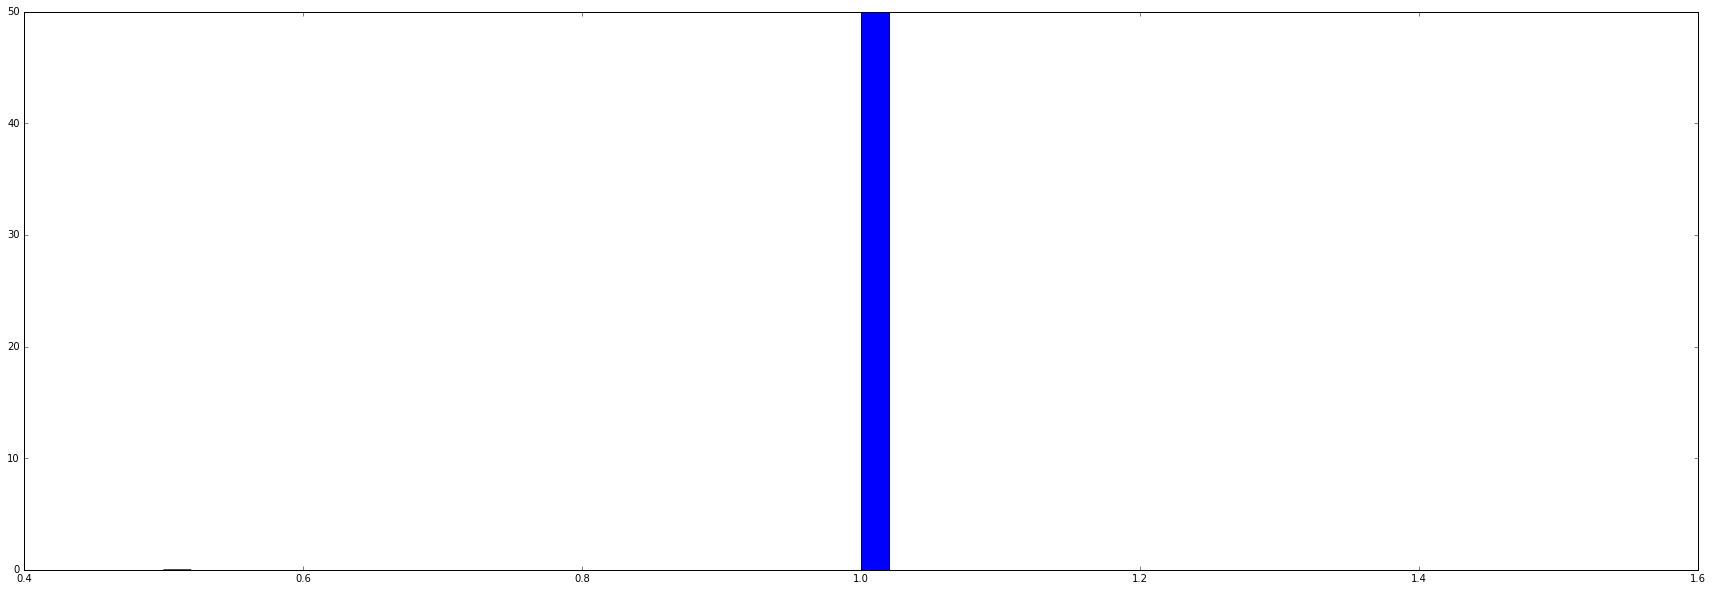

In [36]:
distrib_peak_len(outfile)

**No problem with this dataset**

---
## Summary of the PTM datasets

### Verify datasets homogeneous formating

In [116]:
for f in sorted(glob("./PTM_Clean_Datasets/*.bed")):
    print (f)
    linerange(f, [[10,12]])

./PTM_Clean_Dataset/Carlile_Y_HeLa_hg38_cleaned.bed
10	chr17	16438821	16478678	Y|HeLa|Pseudo_seq|25192136|FAM211A-AS1	1537	+
11	chr2	231455799	231455936	Y|HeLa|Pseudo_seq|25192136|SNROA75	84	-
12	chr6	52995619	52995950	Y|HeLa|Pseudo_seq|25192136|RN7SK	250	+

./PTM_Clean_Dataset/DARNED_human_hg38_inosine_cleaned.bed
10	chr4	482698	482698	A>I|THYMUS|-|15342557|ZNF721	0	-
11	chr4	482700	482700	A>I|THYMUS|-|15342557|ZNF721	0	-
12	chr4	482737	482737	A>I|THYMUS|-|15342557|ZNF721	0	-

./PTM_Clean_Dataset/Dominissini_m1A_HeLa:HEK293:HepG2_hg38_cleaned.bed
10	chr1	826862	826863	m1A|HepG2|M1A_seq|26863196|NR_024321	0	-
11	chr1	827681	827682	m1A|HepG2|M1A_seq|26863196|NR_047524	0	+
12	chr1	942192	942193	m1A|HeLa|M1A_seq|26863196|NM_152486	0	+

./PTM_Clean_Dataset/Dominissini_m6A_HepG2_hg38_cleaned.bed
10	chr1	29553	31094	m6A|HepG2|M6A_seq|22575960|BC048429	0	+
11	chr1	34611	36077	m6A|HepG2|M6A_seq|22575960|F379	0	-
12	chr1	69089	70008	m6A|HepG2|M6A_seq|22575960|OR4F5	0	+

./PTM_Clean_Dataset/Huss

**OK for all the datasets**

### Summary of the datasets 

In [57]:
for f in sorted(glob("./PTM_Clean_Datasets/*.bed")):
    print ("\n", "-"*100)
    print ("Dataset Name\t{}".format(basename(f)))
    print ("Number sites\t{}".format(simplecount(f, ignore_hashtag_line=True)))
    a = colsum(
        f,
        colrange = [3,4,5,6],
        header=False,
        ignore_hashtag_line=True,
        separator=["\t", "|"],
        max_items=20,
        ret_type="dict"
    )
    
    # Get more info via pubmed
    print ("PMID")
    for pmid,count in a[6].items():
        pubmed_info = pmid_to_info(pmid)
        print ("\t*{}\t{}\n\t {}. et al, {}\{}\{}\n\t {}".format(
                pmid,count,
                pubmed_info["first_name"],
                pubmed_info["Year"],
                pubmed_info["Month"],
                pubmed_info["Day"],
                pubmed_info["title"]))
    
    # Simple listing for the other fields
    for title, col in [["RNA PTM",3],["Tissue/cell",4],["Method",5]]:
        print (title)
        print(dict_to_report(a[col], ntab=1, max_items=10, tab="\t", sep="\t"))


 ----------------------------------------------------------------------------------------------------
Dataset Name	Carlile_Y_HeLa_hg38_cleaned.bed
Number sites	8
PMID
	*25192136	8
	 Carlile. et al, 2014\09\05
	 Pseudouridine profiling reveals regulated mRNA pseudouridylation in yeast and human cells.
RNA PTM
	Y	8

Tissue/cell
	HeLa	8

Method
	Pseudo_seq	8


 ----------------------------------------------------------------------------------------------------
Dataset Name	DARNED_human_hg38_inosine_cleaned.bed
Number sites	289998
PMID
	*19478186	412
	 Li. et al, NA\NA\NA
	 Genome-wide identification of human RNA editing sites by parallel DNA capturing and sequencing.
	*15342557	31489
	 Kim. et al, NA\NA\NA
	 Widespread RNA editing of embedded alu elements in the human transcriptome.
	*15258596	3954
	 Levanon. et al, 2004\07\18
	 Systematic identification of abundant A-to-I editing sites in the human transcriptome.
	*21960545	11164
	 Bahn. et al, 2011\09\29
	 Accurate identification of A-

# Gene annotation of the PTM datasets

** The original annotations might not be optimal, and probably not made from an uniq reference annotation file. I will reanotate all the datasets will the last version of gencodegencode.v24.long_noncoding_RNAs.gff3. I split the file in 3 to retain only genes, transcript and exons. I also got the general gencode file containing all the annotated genes in the primary assembly**

 * gencodegencode.v24.long_noncoding_RNAs = Contains the comprehensive gene annotation of lncRNA genes on the reference chromosomes 
 * gencode.v24.annotation = Contains the comprehensive gene annotation on the primary assembly (chromosomes and scaffolds) sequence regions 

** I found a python wrapper package for bedtools to manipulate bed files. I will use it to intersect my bed files containing the positions of the PTM (or peaks) and the gff3 annotation files. This will allow me to get gene names for each positions 

In [41]:
# Installed
import pybedtools

a = pybedtools.example_bedtool('a.bed')
b = pybedtools.example_bedtool('b.bed')

print (a.intersect(b))

chr1	155	200	feature2	0	+
chr1	155	200	feature3	0	-
chr1	900	901	feature4	0	+



---
# Subcellular cell localization datasets


---
## Cabili = HT-FISH data

***Cabili, M. N. et al. Localization and abundance analysis of human lncRNAs at single-cell and single-molecule resolution. Genome Biol 16, (2015)***

- Subcellular Location of lncRNA by RNA FISH
- Nice dataset with Human foreskin fibloblast (hFFs), Human lung fibroblast (hLFs) and HeLA cells
- Limited to a very number of candidate = 34 only
- Could be a good control datasets if we stick to Hela cells

## 

---
# RNA protein interaction datasets

## Hendrickson = fRIP with 24 chromatin related protein

***Hendrickson D G, DR Kelley, D Tenen, B Bernstein, JL Rinn. Widespread RNA binding by chromatin-associated proteins.. Genome Biol 17, 28 (2016).***

- Formaldehyde RNA immunoprecipitation of 24 RPB and chromatin related proteins 
- Really detaillled and extensive datasets to have transcriptome wide lncRNA interacting with chromatin.
- Contain all the list of lncRNA gene significantly enriched in captured factions
- Problem = K562 (myelogenous leukemia line) with highly rearranged genomes... 

---
## Li  / Starbase =  CLIP-Seq data

***JH Li, S Liu, LL Zheng, J Wu, WJ Sun, ZL Wang, H Zhou, LH Qu, JH Yang. Discovery of Protein-lncRNA Interactions by Integrating Large-Scale CLIP-Seq and RNA-Seq Datasets.. Front Bioeng Biotechnol 2, 88 (2014).***

***JH Li, S Liu, H Zhou, LH Qu, JH Yang. starBase v2.0: decoding miRNA-ceRNA, miRNA-ncRNA and protein-RNA interaction networks from large-scale CLIP-Seq data.. Nucleic Acids Res 42, D92-7 (2014).***

- Comprehensive collection of lncRNA protein interaction from 
- Database dates from 2014 => contain datasets up to 2013 = not up to date.
- No specific chromatin protein => have to be crossmatched with protein localization => Done from uniprot = few nuclei pure proteins

**Cross-match Protein location Uniprot with data protein/lncRNA database from Starbase**

Selection of a limited number of candidate CLIP-Seq datasets based on their localization and the experimental conditions:
- Nuclear candidates: ALKBH5, ZC3H7B, FUS, TAF15, hnRNPC, DGCR8, FUS
- Cytoplasmic candidates: AGO1, AGO3, AGO4, FXR1, LIN28B, PUM2